In [1]:
import datetime, urllib, re, math, json, requests,io
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML



try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

# Constants

In [2]:
#** pandas
# change max number of rows to show
pd.set_option('display.max_rows', 300)

#** plotters formats

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cycler import cycler
#* dpi size
plt.rcParams['figure.dpi'] = 200
myFmt = mdates.DateFormatter('%m/%d')
myLocator = mticker.MultipleLocator(7)

default_cycler = (cycler(marker=['.','*','+','s','x']) *
                  cycler(color=['b','g','k','m','y','c','r']) *
                  cycler(linestyle=['-']))

plt.rc('axes', prop_cycle=default_cycler)

#** panda data frame styles
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


# CDC Data 

## URL to the data base

html --> https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html    
json --> https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json

In [3]:
#using cdc data direclty for the US


url = "https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json"

r = requests.get(url)
jdata =r.json()

# get x/y's
x = jdata["data"]["columns"][0][1:]
X = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in x] # x's
v = jdata["data"]["columns"][1][1:] # v's (new cases fo the day)

# interpolate the zeros, since nearly impossible to have no growth
V = pd.Series(np.array(v).astype('int'))
V[V==0]=np.nan #
V = V.interpolate()
if(0): #check data
    print(list(zip(X,V)))
# Remove fist zeros
offsetZero = V.notna().idxmax()
V = V.values[offsetZero:]
X = X[offsetZero:]    

# convert new cases (v) to cumulative cases(y)
dataCdc = pd.Series(V,X).cumsum()
dataCdc[-5:]

2020-03-16    3908.0
2020-03-17    3998.0
2020-03-18    4042.0
2020-03-19    4063.0
2020-03-20    4065.0
dtype: float64

# Domestic/internation number of cases by john hopkins data base
## gui 

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

## githunb 

https://github.com/CSSEGISandData/COVID-19

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series

In [4]:
idx = pd.IndexSlice
      
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_covid19_confirmed_global.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids, set Na for np.NaN (very annoying)
df[["Lat","Long","Province/State"]]=df[["Lat","Long","Province/State"]].fillna("NA")
data=df.copy()
data.set_index(["Country/Region","Province/State","Lat","Long"], inplace=True)
# use before set index , create coutnry sum,
#note this is an over-estimate for us
for ctr in data.index.levels[0].unique() :
    cnt = data.loc[idx[ctr ,:,:,:],:].count()[0]
    if not cnt>1: continue
    print(ctr)
    data.loc[idx[ctr,"NA","NA","NA"],:] =df[
            (~df["Province/State"].str.contains('NA')) &
            (~df["Province/State"].str.contains(','))  &
            (df["Country/Region"]==ctr) ].sum()




#print(data.loc[idx["US","NA","NA","NA"],:].sum())

data.columns = pd.to_datetime(data.columns,format="%m/%d/%y")

dt = data.columns[-1]
print(dt)
if sum(data[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data.drop(columns=dt,inplace=True) 
    dt = data.columns[-2]
if((datetime.datetime.today()-dt).days>1):
    print("***error***")
#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
data.loc["NoChina","NA","NA","NA"]=data.loc[(noChin)].sum()   


dataJHU = data.copy()


Australia
Canada
China
Denmark
France


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


Netherlands
United Kingdom
2020-03-29 00:00:00


In [5]:
#info on styles here
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
import seaborn as sns

dt = dataJHU.columns[-1]
N=5000
# find rows with NA for province/state
#g =dataJHU.filter(like="NA",axis=0)
# find countries with large case counts
g = dataJHU.loc[idx[:,"NA",:,:],:]
g = g[g[dt]>N]

#creat3ea a focus data set
dataFocus = pd.DataFrame()
dataFocus[dataJHU.columns[-1]] = g.loc[(g[dt]>N),  (dataJHU.columns[-1])]
dataFocus[dataJHU.columns[-2]] = g.loc[(g[dt]>N),  (dataJHU.columns[-2])]
dataFocus["delta"]             = g.loc[:,(g.columns[-1])]-dataJHU.loc[:,g.columns[-2]]
dataFocus["delta%"]            = dataFocus["delta"] / g.loc[:,(g.columns[-1])]
dataFocus=dataFocus.reset_index().drop(columns=["Lat",'Long',"Province/State"]).set_index("Country/Region")

# gradient across two colols, second is one color
cm = sns.diverging_palette(150,10, n=12,l=55,center='light',as_cmap=True)
cm = sns.light_palette('red',as_cmap=True)

display(dataFocus.sort_values(by="delta",ascending=False).style
    .background_gradient(cmap=cm, subset=['delta%'])
    .format({'delta%': "{:.1%}"})
    )



dataStates= pd.DataFrame()
dataStates[dataJHU.columns[-1]]=dataJHU.loc[idx["US",:,:,:],:].sort_values(by=dt,ascending=False)[dataJHU.columns[-1]]
dataStates[dataJHU.columns[-2]]=dataJHU.loc[idx["US",:,:,:],:].sort_values(by=dt,ascending=False)[dataJHU.columns[-2]]
dataStates["delta"]  = dataStates[dataJHU.columns[-1]]- dataStates[dataJHU.columns[-2]]
dataStates["delta%"] = dataStates["delta"] / dataStates[dataJHU.columns[-1]]
dataStates=dataStates.reset_index().drop(columns=["Lat",'Long']).set_index("Country/Region","Province/State")
##display(HTML(dataStates.head(7).to_html()))
#display(dataStates.head(7).reset_index(drop=True).style
#    .background_gradient(cmap=cm, subset=['delta%'])
#    .format({'delta%': "{:.1%}"})
#)

#display_side_by_side(dataFocus.sort_values(by="delta",ascending=False),dataStates.head(15))

# create list of countires to focus on for later processing
countriesFocused = [dataJHU.index.levels[0][i] for i in g.index.labels[0]]
countriesFocused = countriesFocused+["Japan"];


,2020-03-29 00:00:00,2020-03-28 00:00:00,delta,delta%
Country/Region,,,,
NoChina,649284,588898,60386,9.3%
US,140886,121478,19408,13.8%
Spain,80110,73235,6875,8.6%
Italy,97689,92472,5217,5.3%
Germany,62095,57695,4400,7.1%
Iran,38309,35408,2901,7.6%
France,40174,37575,2599,6.5%
United Kingdom,19522,17089,2433,12.5%
Turkey,9217,7402,1815,19.7%


# 3rd party data, but more reliable and better format compared to JHU,

open source and peer review

In [49]:
df = pd.read_csv("https://coronadatascraper.com/timeseries-tidy.csv")
df.fillna("NA",inplace=True);
dataTCS =df.set_index(["city","county","state","country","type"])

In [61]:
idx = pd.IndexSlice
dataTCS.loc[idx["NA","NA","NA","USA","deaths"],:].value
#dataTCS.index.levels[4]

city  county  state  country  type  
NA    NA      NA     USA      deaths       1
                              deaths       1
                              deaths       6
                              deaths       7
                              deaths      11
                              deaths      12
                              deaths      14
                              deaths      17
                              deaths      21
                              deaths      22
                              deaths      56
                              deaths      68
                              deaths      40
                              deaths      47
                              deaths      54
                              deaths      63
                              deaths      85
                              deaths     108
                              deaths     118
                              deaths     160
                              deaths     219
                  

# 3rd party data source real time data, from a spin of JHU
http://blog.lazd.net/coronadatascraper/

In [38]:
idx = pd.IndexSlice
df = pd.read_csv("http://coronadatascraper.com/data.csv",parse_dates=True)
df[["city","county","state","country"]] =df[["city","county","state","country"]].fillna("NA")
dataCS =df.set_index(["city","county","state","country"])


# create county with state as NA, but summin across states
for ctr in dataCS.index.levels[3]:
    if not idx["NA","NA","NA",ctr]    in dataCS.index: 
        print(ctr)
        dataCS.loc[idx["NA","NA","NA",ctr],:] =dataCS.loc[idx["NA","NA",:,ctr],:].sum()
        
#use index slice for more easy/clean access

# example access
IClmns= idx["cases","death","recovered","tested",'url']
ctrMask = dataCS["cases"] > 1e4
dataCS.loc[idx["NA","NA","NA",ctrMask],IClmns].sort_values(by="cases",ascending=False)



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


cases  death  recovered    tested  \
city county state country                                       
NA   NA     NA    USA      139061    NaN        NaN  896900.0   
                  ITA       97689    NaN    13030.0  454030.0   
                  CHN       82122    NaN        NaN       NaN   
                  ESP       78797    NaN    14709.0       NaN   
                  DEU       62095    NaN        NaN       NaN   
                  FRA       40174    NaN        NaN       NaN   
                  IRN       38309    NaN        NaN       NaN   
                  GBR       19522    NaN        NaN       NaN   
                  CHE       14829    NaN        NaN       NaN   
                  NLD       10866    NaN        NaN       NaN   
                  BEL       10836    NaN        NaN       NaN   

                                                                         url  
city county state country                                                     
NA   NA     NA    USA                   https://covidtracking.com/api/states  
                  ITA      https://raw.githubusercontent.com/pcm-dpc/COVI...  
                  CHN             https://github.com/CSSEGISandData/COVID-19  
                  ESP      https://github.com/datadista/datasets/tree/mas...  
                  DEU             https://github.com/CSSEGISandData/COVID-19  
                  FRA             https://github.com/CSSEGISandData/COVID-19  
                  IRN             https://github.com/CSSEGISandData/COVID-19  
                  GBR             https://github.com/CSSEGISandData/COVID-19  
                  CHE             https://github.com/CSSEGISandData/COVID-19  
                  NLD             https://github.com/CSSEGISandData/COVID-19  
                  BEL             https://github.com/CSSEGISandData/COVID-19

In [ ]:
idx = pd.IndexSlice

# must have colons liberally used, firt two colons for city/county and last colon for all columns
#option 1 for access
dataCS.loc[("NA", "Los Angeles County", "CA", "USA")]
#option 2 for access, using idx must have colons liberally used, firt two colons for city/county and last colon for all columns
dataCS.loc[idx[:, "San Diego County", "CA", "USA"],IClmns]
#total cases in ca
dataCS.loc[idx["NA","NA", "CA", "USA"],:]["cases"]
display(HTML(dataCS.loc[idx[:, :, "CA", "USA"],IClmns].to_html()))

dataCS.loc[idx[:, "San Diego County", "CA", "USA"],["url"]].values

# Testing numbers by Covid tracking (US only)

https://covidtracking.com

In [8]:
def get_csv_from_url(link):
    response = requests.get(link)
    
    file_object = io.StringIO(response.content.decode('utf-8'))
    return pd.read_csv(file_object)
#not PosNeg is total count subtracting pending

# us daily data -->
links=\
 ["https://covidtracking.com/api/us.csv",     # US current
 "http://covidtracking.com/api/us/daily.csv", # time series  
 "https://covidtracking.com/api/states.csv",  # state current
  "https://covidtracking.com/api/states/daily.csv"] # state time series

# how to get state data time series -->
# "https://covidtracking.com/api/states/daily?state=CA",#states
# "https://covidtracking.com/api/states/daily?state=NY",
dataCovTr = get_csv_from_url(links[0]);
dfUST     = get_csv_from_url(links[1]);
dfStates  = get_csv_from_url(links[2]);
dfTStates = get_csv_from_url(links[3]);

ts = pd.to_datetime(dfUST["date"],format="%Y%m%d")
dfUST.drop("date",axis=1,inplace=True)
dfUST.set_index(ts, inplace=True)

ts = pd.to_datetime(dfTStates["date"],format="%Y%m%d")
dfTStates.drop("date",axis=1,inplace=True)
dfTStates.set_index(ts, inplace=True)


In [9]:
# remove na from us time  series
dfUST["Case Delta"]=dfUST.sort_values(by="date",axis=0)["positive"].diff().fillna(-1)
dfUST["Test Delta"]=dfUST.sort_values(by="date",axis=0)["totalTestResults"]   .diff().fillna(-1)


# add negative rate for states current
dfStates["NegRate%"]=dfStates["negative"]/dfStates["totalTestResults"] * 100
dfUST   ["NegRate%"]=dfUST   ["negative"]/dfUST   ["totalTestResults"] * 100


display(HTML(dataCovTr.to_html()))
display(HTML(dfUST.sort_values('date',axis=0, ascending=False).head(7).to_html()))
display(HTML(
    dfTStates.loc[dfTStates.index[0]].sort_values(by="positive",ascending=False).head(7).to_html()))
#display(HTML(dfStates.sort_values(by="positive",ascending=False).head(5).to_html()))


,positive,negative,posNeg,hospitalized,death,total,hash,lastModified,notes,totalTestResults
0,141950,714596,856546,19941,2464,856546,9514513cd288f3258f41b1882116a645da479c6d,3/30/2020,"Please stop using the ""total"" and ""posNeg"" fie...",856546


,states,positive,negative,posNeg,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Case Delta,Test Delta,NegRate%
date,,,,,,,,,,,,,,,,,,,,
2020-03-29,56,139061,692290,831351,65549,19730.0,2428.0,896900,0bcb1178e16a889408a98222caae4bd49fe3d9b8,2020-03-29T20:00:00Z,831351,NaN,463.0,3001.0,74820.0,20827.0,95647.0,20827.0,95647.0,83.272890
2020-03-28,56,118234,617470,735704,65712,16729.0,1965.0,801416,a54933aec2de2cb0f418ffbc85c6c58d7481be77,2020-03-28T20:00:00Z,735704,NaN,435.0,3011.0,90250.0,18821.0,109071.0,18821.0,109071.0,83.929135
2020-03-27,56,99413,527220,626633,60094,13718.0,1530.0,686727,5e9611f927d035074ac65594ad30669ef8299d75,2020-03-27T20:00:00Z,626633,NaN,367.0,3587.0,88617.0,18678.0,107295.0,18678.0,107295.0,84.135371
2020-03-26,56,80735,438603,519338,60251,10131.0,1163.0,579589,77e73bd9ca5316e76685e4fd31fd7adbd7ba4f45,2020-03-26T20:00:00Z,519338,NaN,263.0,3995.0,80999.0,16807.0,97806.0,16807.0,97806.0,84.454248
2020-03-25,56,63928,357604,421532,51235,6136.0,900.0,472767,99e1bdff6a809d12b2e76a9e7c8a678d32a6f670,2020-03-25T20:00:00Z,421532,NaN,225.0,1668.0,64846.0,11974.0,76820.0,11974.0,76820.0,84.834366
2020-03-24,56,51954,292758,344712,14433,4468.0,675.0,359145,eaedae24caa3d2c2dcbad823b248b729972e9960,2020-03-24T20:00:00Z,344712,NaN,204.0,1143.0,55437.0,9802.0,65239.0,9802.0,65239.0,84.928288
2020-03-23,56,42152,237321,279473,14571,3325.0,471.0,294044,cca0aa4d7ad5221bf9e3b542fb56c03418b79874,2020-03-23T20:00:00Z,279473,NaN,73.0,771.0,43858.0,10273.0,54131.0,10273.0,54131.0,84.917327


,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,
2020-03-29,NY,59513.0,112847.0,NaN,12075.0,965.0,172360,ba807849425122f97cff754bfca452232a1e75ce,2020-03-29T20:00:00Z,172360,36,237.0,2021.0,9231.0,7195.0,16426.0
2020-03-29,NJ,13386.0,22216.0,NaN,NaN,161.0,35602,5e0cce3ce15a05bc385736f7f690e041feb4f2d9,2020-03-29T20:00:00Z,35602,34,21.0,0.0,2830.0,2262.0,5092.0
2020-03-29,CA,5708.0,20549.0,64400.0,1034.0,123.0,90657,c364ec885909accfd4baf8e2d329903900870ba9,2020-03-29T20:00:00Z,26257,6,22.0,0.0,0.0,1065.0,1065.0
2020-03-29,MI,5486.0,11893.0,NaN,NaN,132.0,17379,25fd0b3fada36382067e735f2ea785fcbb58376a,2020-03-29T20:00:00Z,17379,26,40.0,0.0,2784.0,1829.0,4613.0
2020-03-29,MA,4955.0,34111.0,NaN,399.0,48.0,39066,85320d5eb34b32da6ffe44dfb937835574a335a1,2020-03-29T20:00:00Z,39066,25,4.0,49.0,3319.0,698.0,4017.0
2020-03-29,IL,4596.0,23166.0,NaN,NaN,65.0,27762,e6e6b00bdc70ca71fc14b3056568dfc40097d750,2020-03-29T20:00:00Z,27762,17,18.0,0.0,1166.0,1105.0,2271.0
2020-03-29,WA,4310.0,54896.0,NaN,254.0,189.0,59206,02bb082a97f1ddda79562a855dd090e632e2e5e9,2020-03-29T20:00:00Z,59206,53,14.0,0.0,5881.0,587.0,6468.0


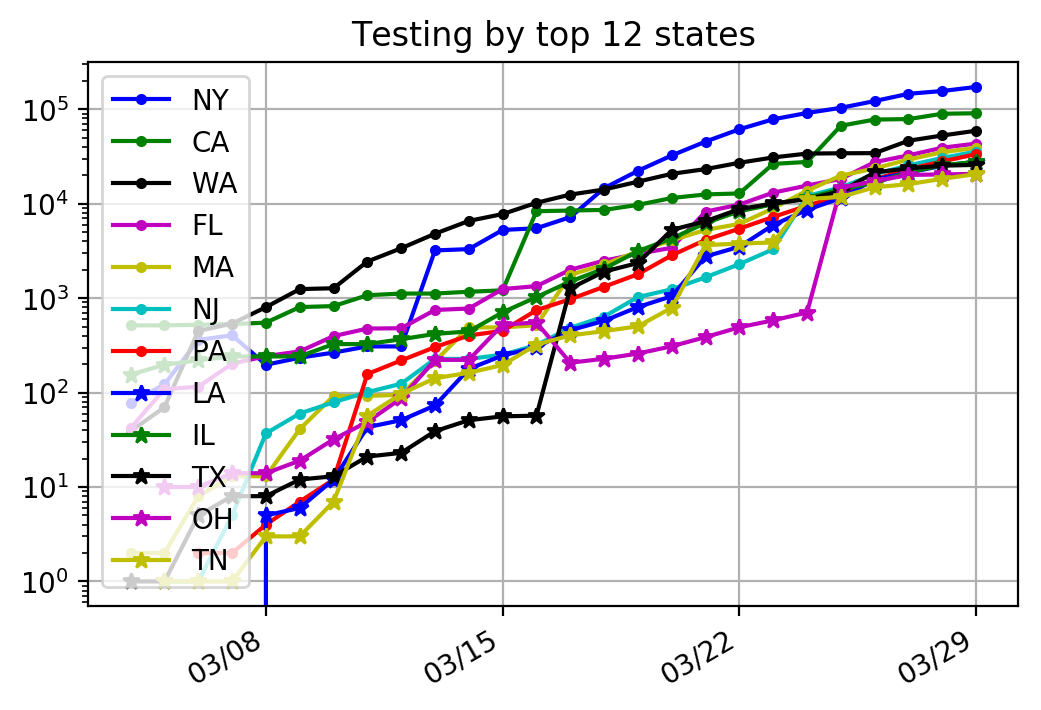

In [10]:
# get top 7 states (using  current)
fig,ax=plt.subplots(1,1,)
stFocused = dfStates.sort_values(by="total",ascending=False).head(12)["state"]
for st in stFocused:
    y = dfTStates[dfTStates["state"]==st].sort_values(by='date',ascending=True)["total"]
    
    ax.semilogy(y,label=st)

ax.xaxis.set_major_locator(myLocator)
ax.xaxis.set_major_formatter(myFmt)
ax.grid()
plt.legend()
fig.autofmt_xdate()
plt.title("Testing by top 12 states");
#dfTStates[(dfTStates["state"]=="CA") & (dfTStates["positive"]>100)]["positive"].index


positive rate 15.50%
hospital rate 14.19%
death rate 1.75%


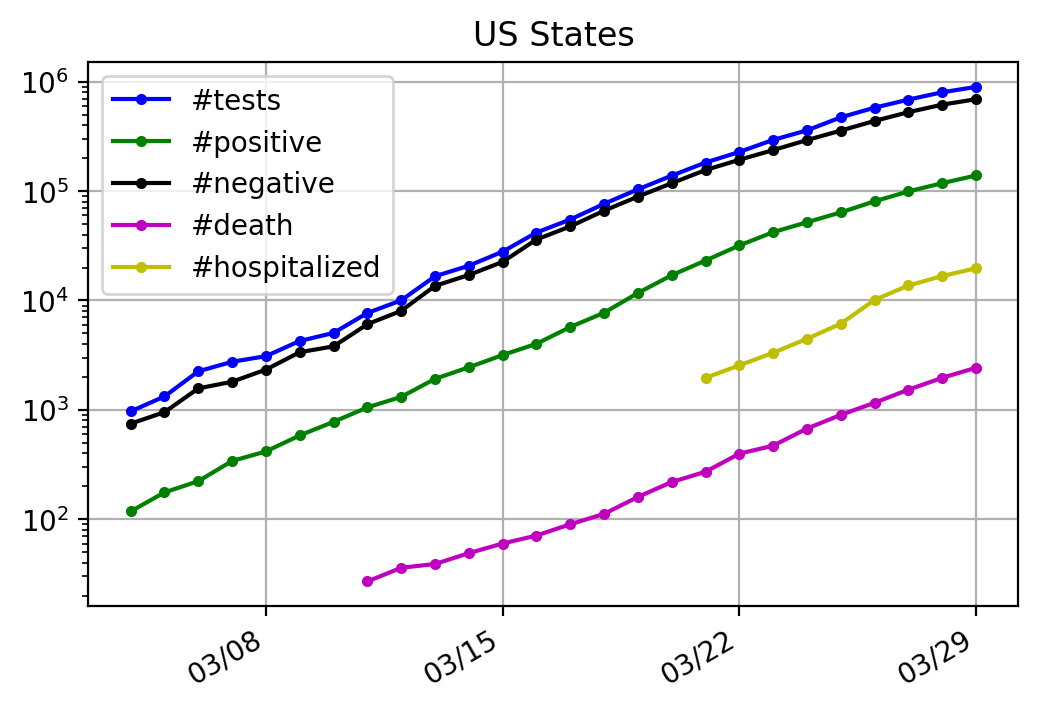

In [18]:
fig,ax = plt.subplots(1,1)
g= dfUST.sort_values(by="date",ascending=True)

ax.semilogy(g['total'],   label="#tests")
ax.semilogy(g['positive'],label="#positive")
ax.semilogy(g['negative'],label="#negative")
ax.semilogy(g['death'],   label="#death")
ax.semilogy(g['hospitalized'],   label="#hospitalized")

ax.xaxis.set_major_locator(myLocator)
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("US States");
ax.grid()
plt.legend()
fig.autofmt_xdate()
print("positive rate %.2f%%" %(100*g['positive'][-1]/g['total'][-1]))
print("hospital rate %.2f%%" %(100*g['hospitalized'][-1]/g['positive'][-1]))
print("death rate %.2f%%"%(100*g['death'][-1]/g['positive'][-1]))

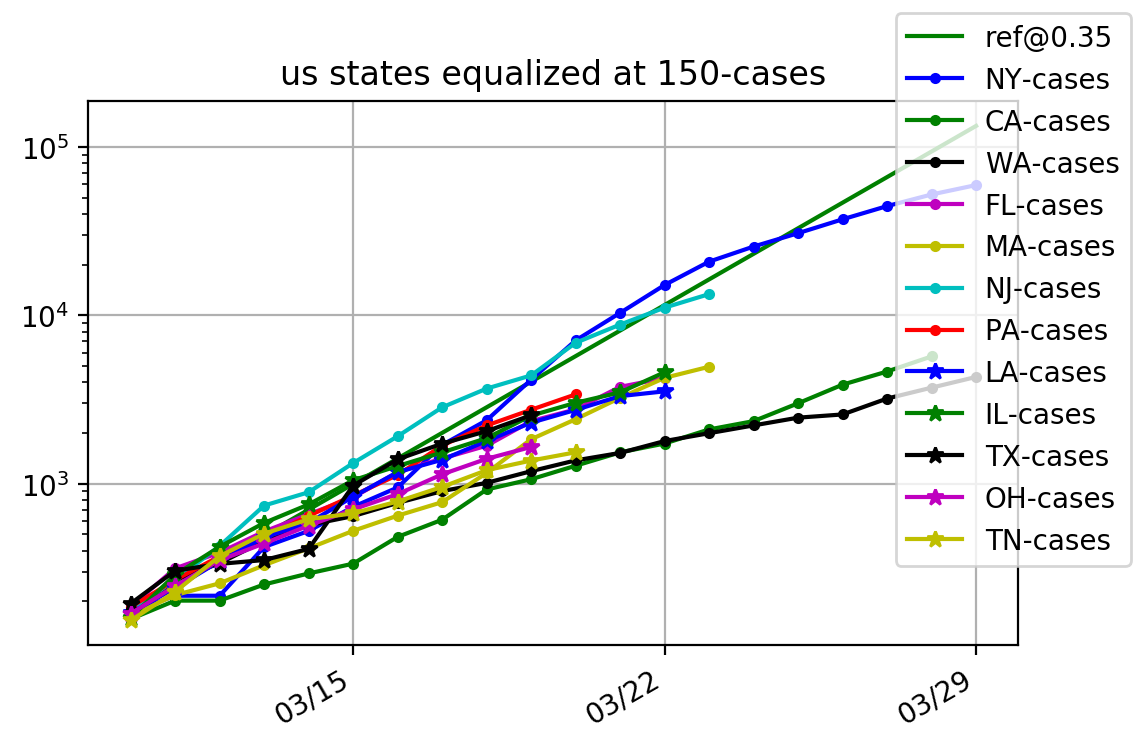

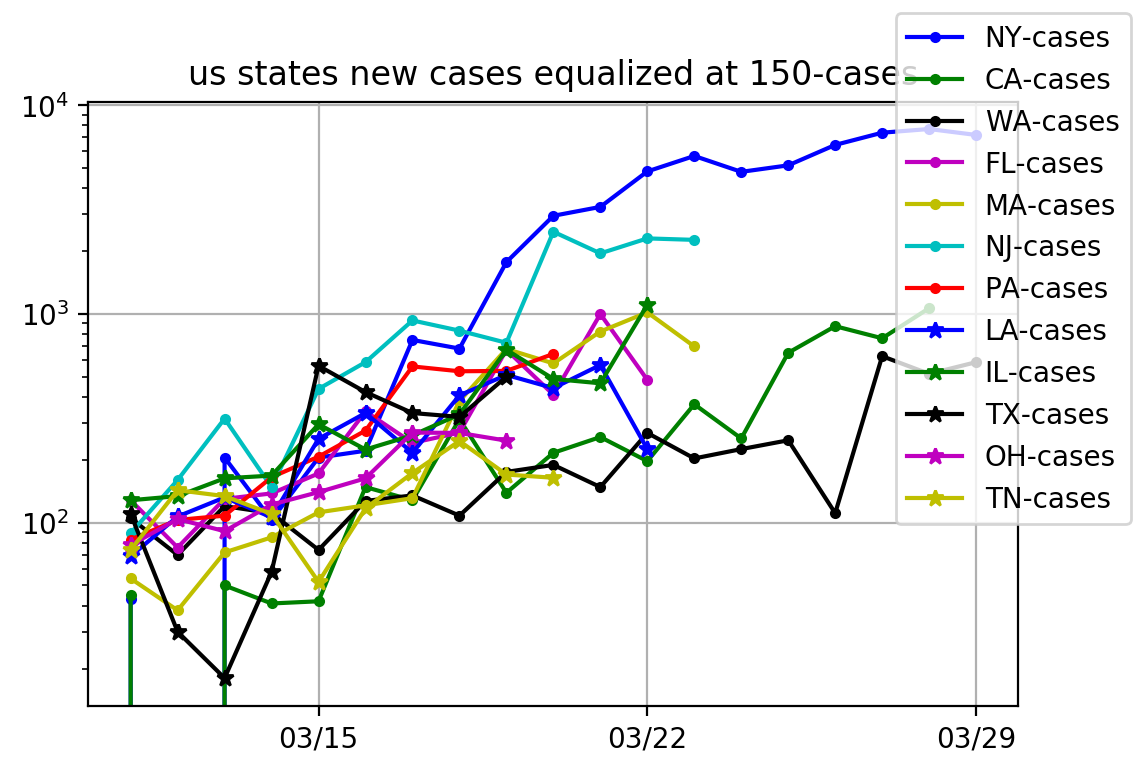

In [12]:
dfTStates.sort_values(by='date',ascending=True,inplace=True)

def food(state,rate,M,ax):
    y = dfTStates[(dfTStates["state"]==state) & (dfTStates["positive"]>M)]["positive"]
    y0=y[0]
    #start date
    dts = y.index[0]
    N=(dfTStates[(dfTStates["state"]==state)].index[-1] - dts).days+1
    x=np.arange(0,N);
    xdt = [dts +datetime.timedelta(days=d) for d in range(0,N)]
    ye = y0* np.exp(rate * x)
    
    return dts,xdt,ye


fig,ax   = plt.subplots(1,1)
fig2,ax2 = plt.subplots(1,1)
#focused state
st="NY"
#number of ases
M=150
rate=0.35
[dts,xdt,ye] = food(st,rate,M,ax)
ax.semilogy(xdt,ye,'g-',label="ref@%.2f"%rate)



for idx in np.arange(0,12):
    g=dfTStates[dfTStates["state"]==stFocused.values[idx]]["positive"]
    y = g[g>M]
    N=sp.size(y)
    xdt = [dts +datetime.timedelta(days=d) for d in range(0,N)]
    lbl= "%s-cases"%stFocused.values[idx];
    ax.semilogy(xdt,y,label=lbl)
    ax2.semilogy(xdt[1:],np.diff(y),label=lbl)

ax.grid();                            ax2.grid()
ax.xaxis.set_major_locator(myLocator);ax2.xaxis.set_major_locator(myLocator)
ax.xaxis.set_major_formatter(myFmt)  ;ax2.xaxis.set_major_formatter(myFmt)
ax.set_title ("us states equalized at %d-cases"%M);
ax2.set_title("us states new cases equalized at %d-cases"%M);
fig.legend();                        fig2.legend()
fig.autofmt_xdate()
idx= 0


In [20]:
# create new groups
# dont use string for UR, but the 50 states
countries={ "NoChina":"NoChina",
            "China":"China",
            "South Korea":"South Korea",
            "Japan":"Japan",
            "Italy":"Italy",            
            "South Korea":"Korea, South",
            "US":"US"}


# Simple model 
## use exponentia, until inflection point of logistic curve

current count = previous count + E * p * previous count

or 

current count = (1 + E * p) * previous count

E = is average number of people someone infected is exposed to each day

p = propabatiity of each exposed ecoming an infection


Growth Rate NoChina:1.14


<Figure size 1200x800 with 0 Axes>

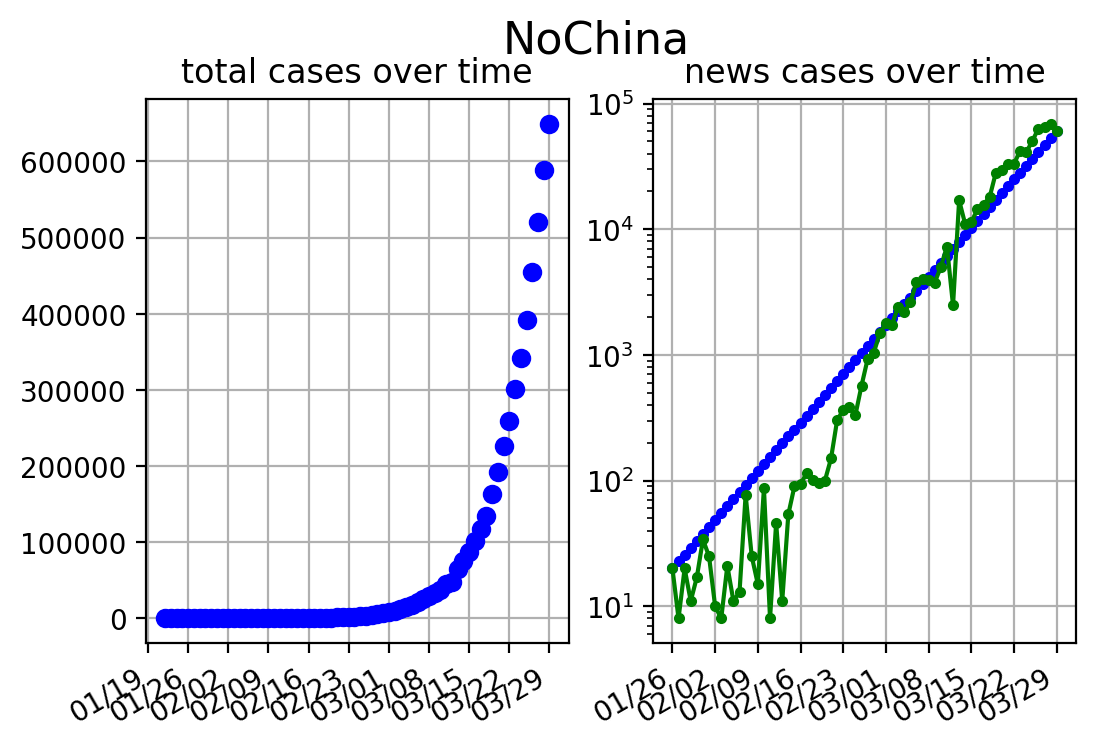

In [21]:
#assume (1+E*P) is 120%


#determine slope and plot
for name in ["NoChina"]:
    ctr = countries[name]
    plt.figure()
    vals= dataJHU.loc[ctr].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    #print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(max(lv)-lv[0])/(sp.size(lv))

    print("Growth Rate %s:%.2f"%(ctr,math.pow(10,m)))
    #print()
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    ax[1].grid()
#    ax[1].legend()
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].set_title("news cases over time");

    fig.autofmt_xdate()
    
    #---
    y=dataJHU.loc[ctr].sum()
    ax[0].plot_date(y.index,y.values)        
    ax[0].grid()
#    ax[0].legend()
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].set_title("total cases over time");

    fig.autofmt_xdate()
    
    fig.suptitle('%s'% name, fontsize=16)


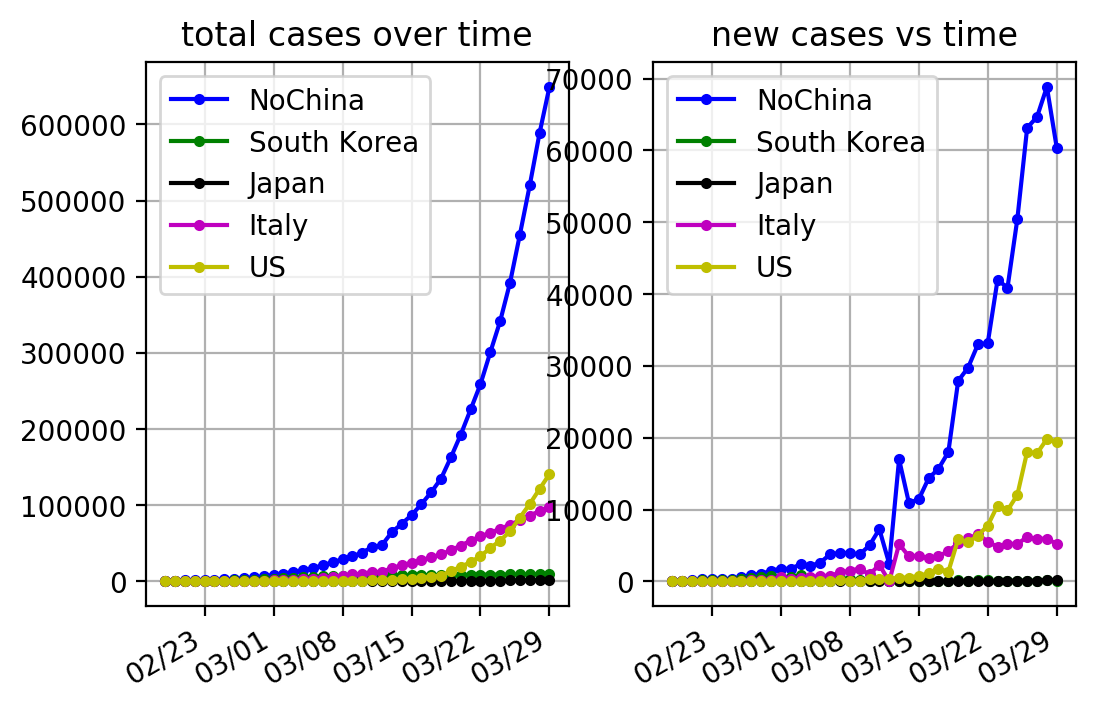

In [22]:
offset=28
#ignore china here
fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    y = dataJHU.loc[(country)].sum()
    ax[0].plot(y.index[offset:],y.values[offset:],label=name)
#ax[0].xaxis.set_major_locator(myLocator)
ax[0].grid()
ax[0].legend()
ax[0].xaxis.set_major_locator(myLocator)
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= dataJHU.loc[(country)].sum().diff()
    ax[1].plot(vals[offset:],label=name)
ax[1].xaxis.set_major_locator(myLocator)
ax[1].grid()
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].legend()
ax[1].set_title("new cases vs time");

fig.autofmt_xdate()



# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far.

A = the peak infection rate (4600 case/day)

B = the width parameter (0.116)

C = the center date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


In [23]:
import scipy.signal
def getTimedGrowthRate(df,pidx,Nlength=3, debug=False,plot=False): 
    yo = df.loc[pidx,:].sum().values
    y  = sp.signal.savgol_filter(yo, 5, 2, mode='nearest')
    if(plot):
        plt.figure()
        plt.plot(yo,label="original")
        plt.plot(y, label="smoothed")
        plt.legend()
    
     # daily new case
    v = np.diff(y)#.values[1:]



#     # find the start date 
    idxs = np.argwhere(y>100)[2][0]    
    dts  = df.loc[pidx,:].columns[idxs]
    
#     #find the inflection point (max of v)
    idxi = sp.size(v)-1 #np.argmax(v)
    dti  = df.loc[pidx,:].columns[idxi]
    
    if(debug):print("%d %d %d" %(idxs, idxi,sp.size(y)))
    
    vGR = np.zeros(idxi-idxs-(Nlength-1))       
    i0= 0
    
    
    for i in range(idxs,idxi-(Nlength-1)):
        lv = sp.log10(y[i:i+Nlength])
        #lv = y[i:i+Nlength]
        if(debug):print(lv)
        m=(lv[-1]-lv[0])/Nlength
        if(debug):print("%d %.2f %.2f"%(i,m, np.exp(m)))
        vGR[i0]=m             
        i0+=1
    if(plot):
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax2 = ax1.twinx()
        ax2.plot(vGR,'b+')
        ax1.semilogy(y[idxs:idxi],'r')
        ax1.semilogy(v[idxs:idxi],'g')
    return vGR

country ="US"
#pidx = pd.IndexSlice[country,"NA",:,:]
#getTimedGrowthRate(dataJHU,pidx,plot=True,debug=False,Nlength=5);
#dataJHU.loc[pidx].sum()


In [24]:
# place a model on all countries with high counts
# cumulative model
def cumModel(t,A,B,C):
    return A/(np.cosh( B * (t-C))**2)        
# new case model
def newcModel(t,A,B,C):        
    return A/B * ( np.tanh( B * (t-C)) + 1 )
# logistic model
def logisModel(t,K,Q,B,v,M):
    # assume A is 0 (asymptote ), keep C as 1 for normal case
    #return A + (K-A) / ( (C + Q * np.exp(-B * (t-M)))**(1./v) )
    return K / ( (1+Q * np.exp(-B * (t-M)))**(1./v) )

       Austria K=1,048,723 B=0.03 Q=0.22 v=0.04 Ndays to peak=(52)
       Belgium K=2,077,482 B=0.06 Q=3.00 v=0.25 Ndays to peak=(41)
        France K=1,783,017 B=0.04 Q=0.29 v=0.06 Ndays to peak=(39)
       Germany K=1,858,948 B=0.04 Q=0.35 v=0.08 Ndays to peak=(31)
          Iran K=1,286,242 B=0.02 Q=0.24 v=0.06 Ndays to peak=(60)
         Italy K=155,285 B=0.13 Q=0.83 v=0.51 Ndays to peak=(-6)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':


  Korea, South K=9,113 B=0.18 Q=0.00 v=0.00 Ndays to peak=(-29)
   Netherlands K=905,346 B=0.03 Q=0.15 v=0.03 Ndays to peak=(48)
      Portugal K=1,507,502 B=0.04 Q=0.44 v=0.06 Ndays to peak=(49)
         Spain K=1,179,953 B=0.05 Q=0.00 v=0.00 Ndays to peak=(21)
   Switzerland K=1,104,426 B=0.03 Q=0.06 v=0.01 Ndays to peak=(52)
        Turkey K=862,615 B=0.07 Q=0.42 v=0.06 Ndays to peak=(23)
United Kingdom K=1,539,697 B=0.05 Q=1.24 v=0.17 Ndays to peak=(34)
            US K=2,935,668 B=0.07 Q=0.62 v=0.14 Ndays to peak=(18)
        Canada K=1,613,001 B=0.04 Q=0.35 v=0.06 Ndays to peak=(41)
         China K=162,301 B=0.22 Q=0.49 v=1.00 Ndays to peak=(-50)
       NoChina K=1,935,652 B=0.17 Q=2.75 v=1.00 Ndays to peak=(3)
         Japan K=28,245 B=0.02 Q=0.19 v=0.06 Ndays to peak=(56)


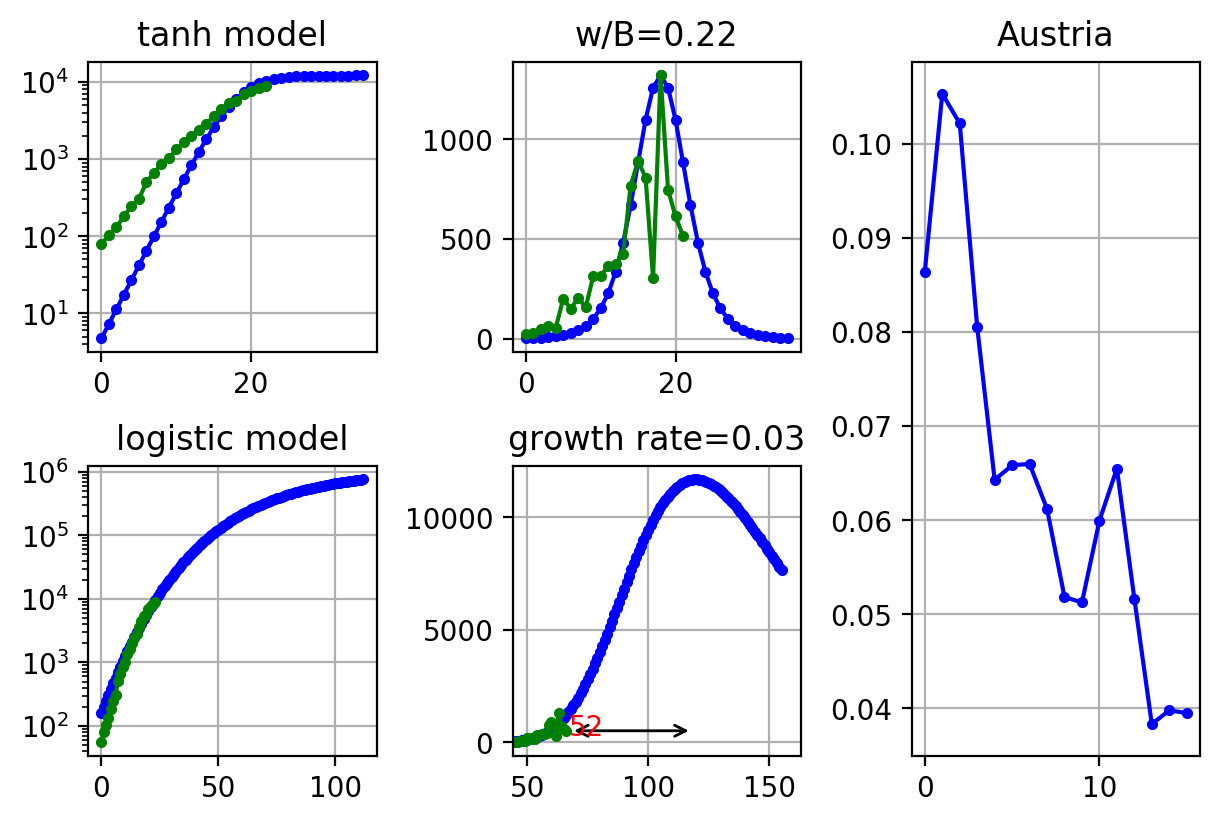

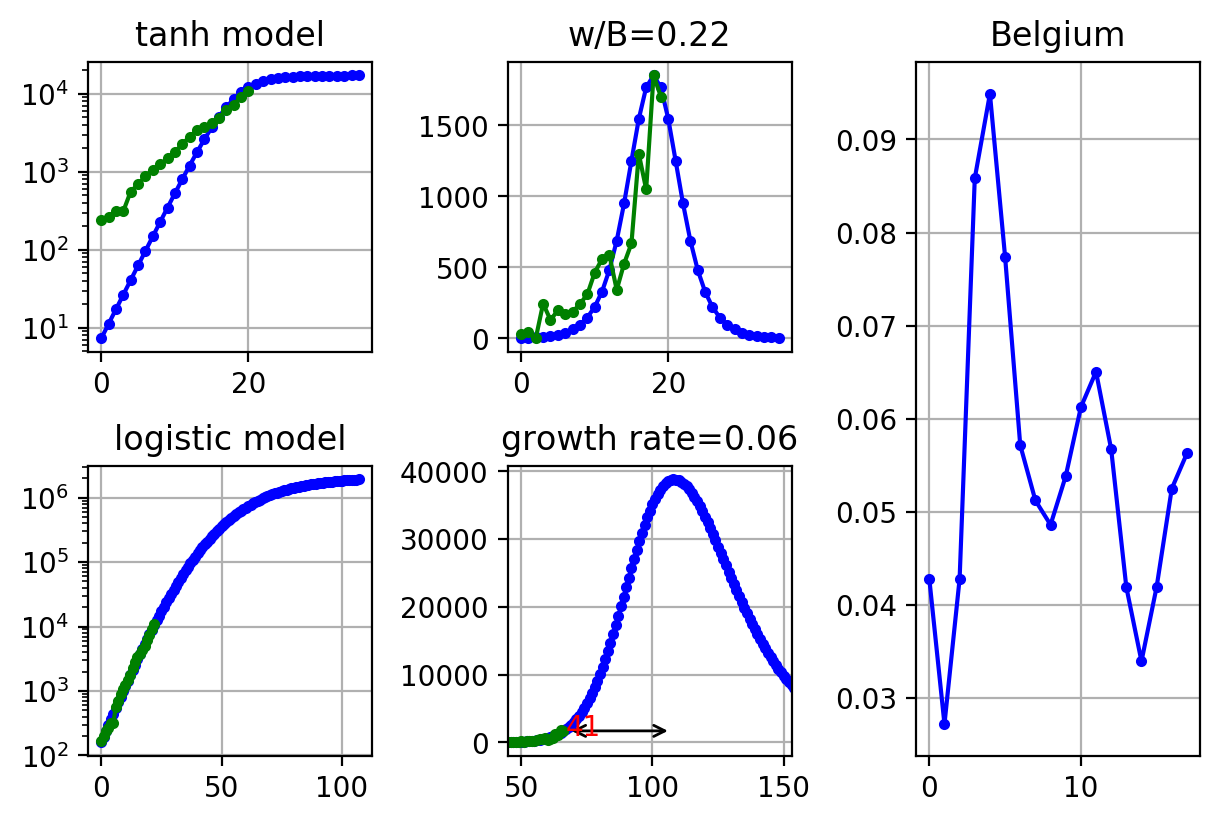

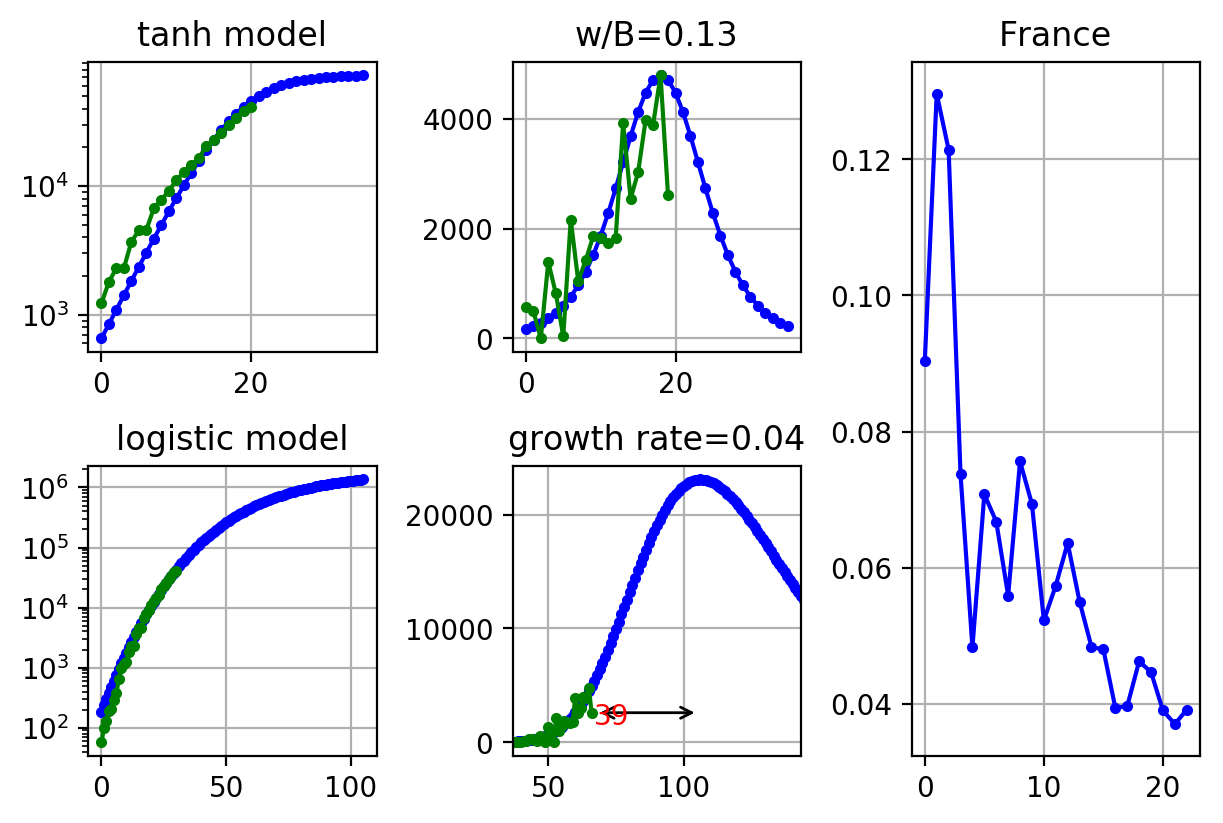

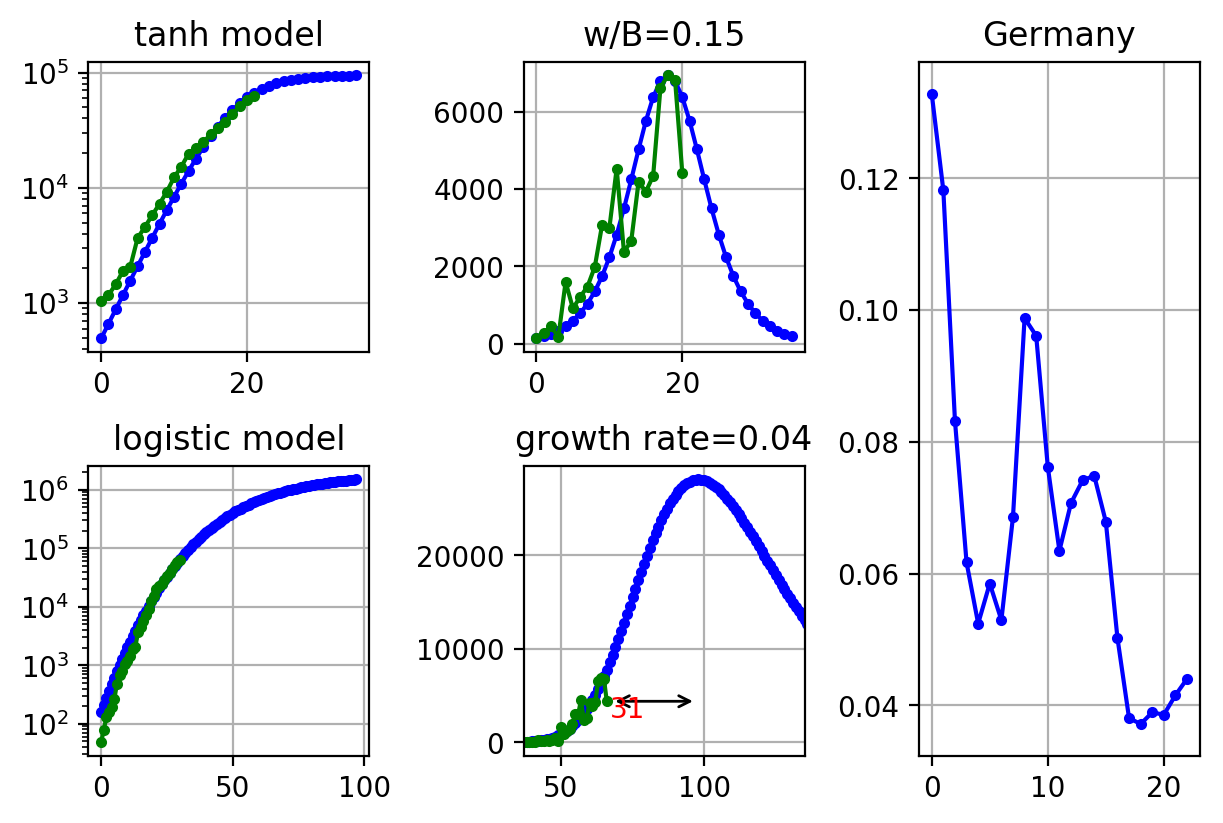

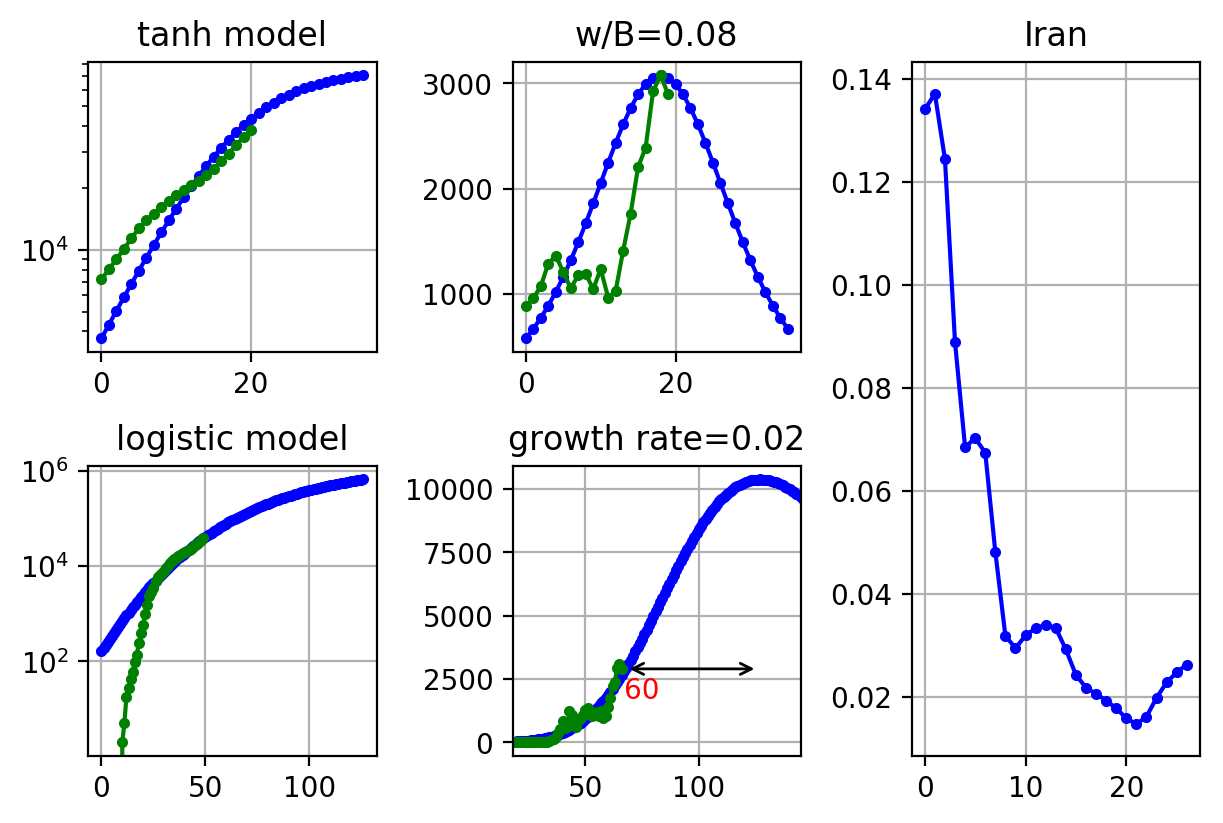

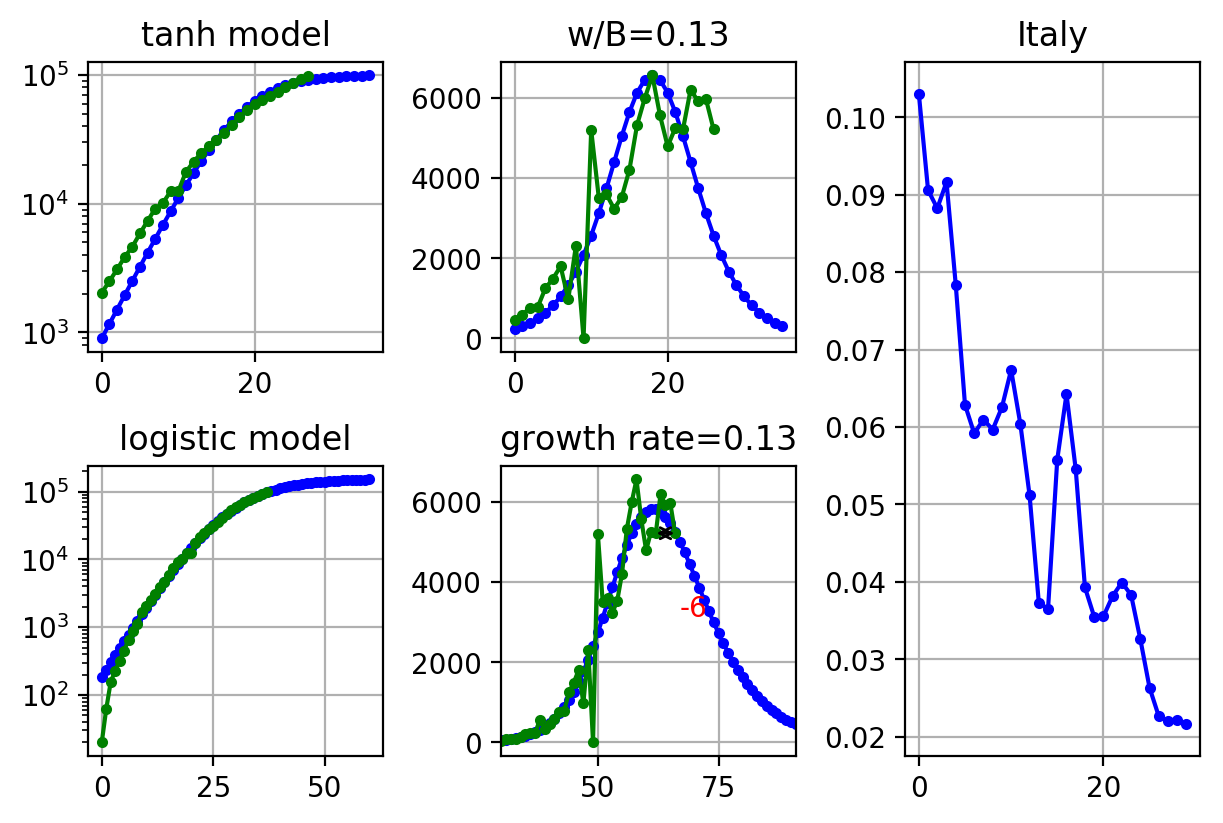

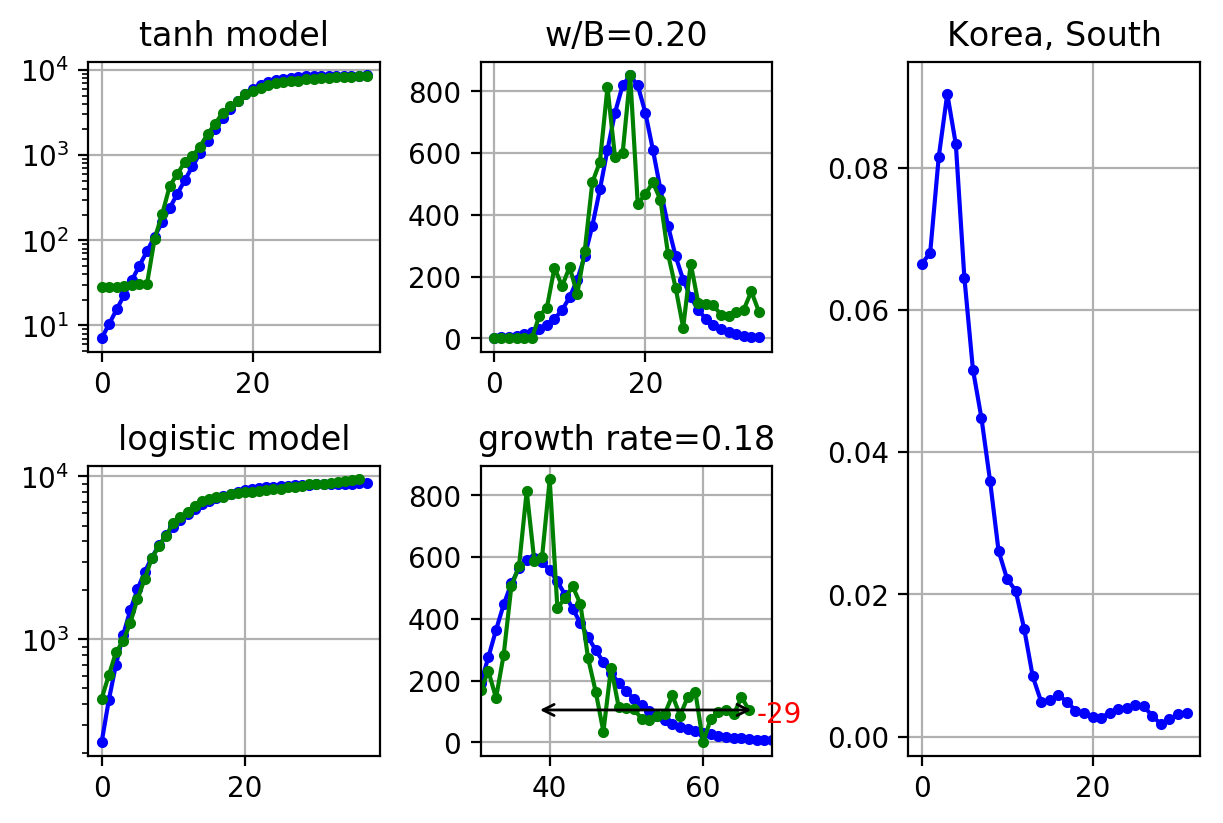

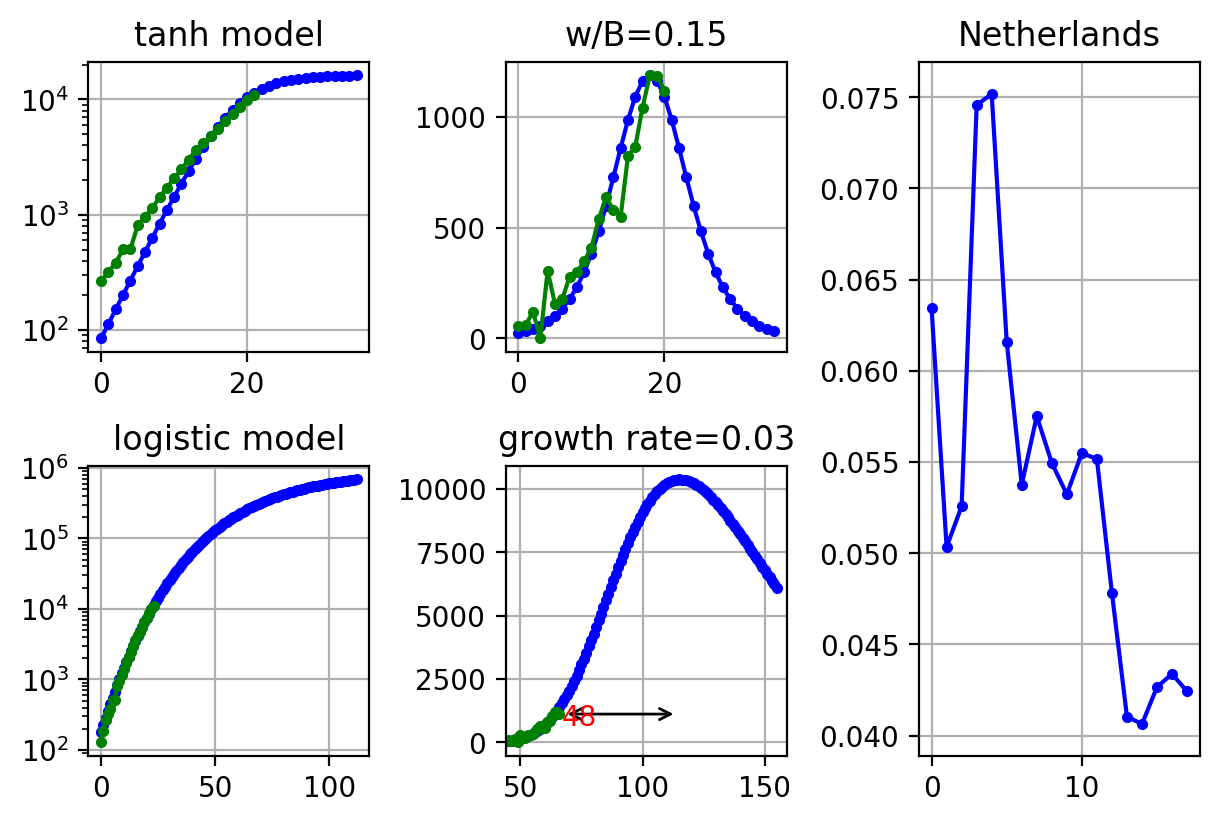

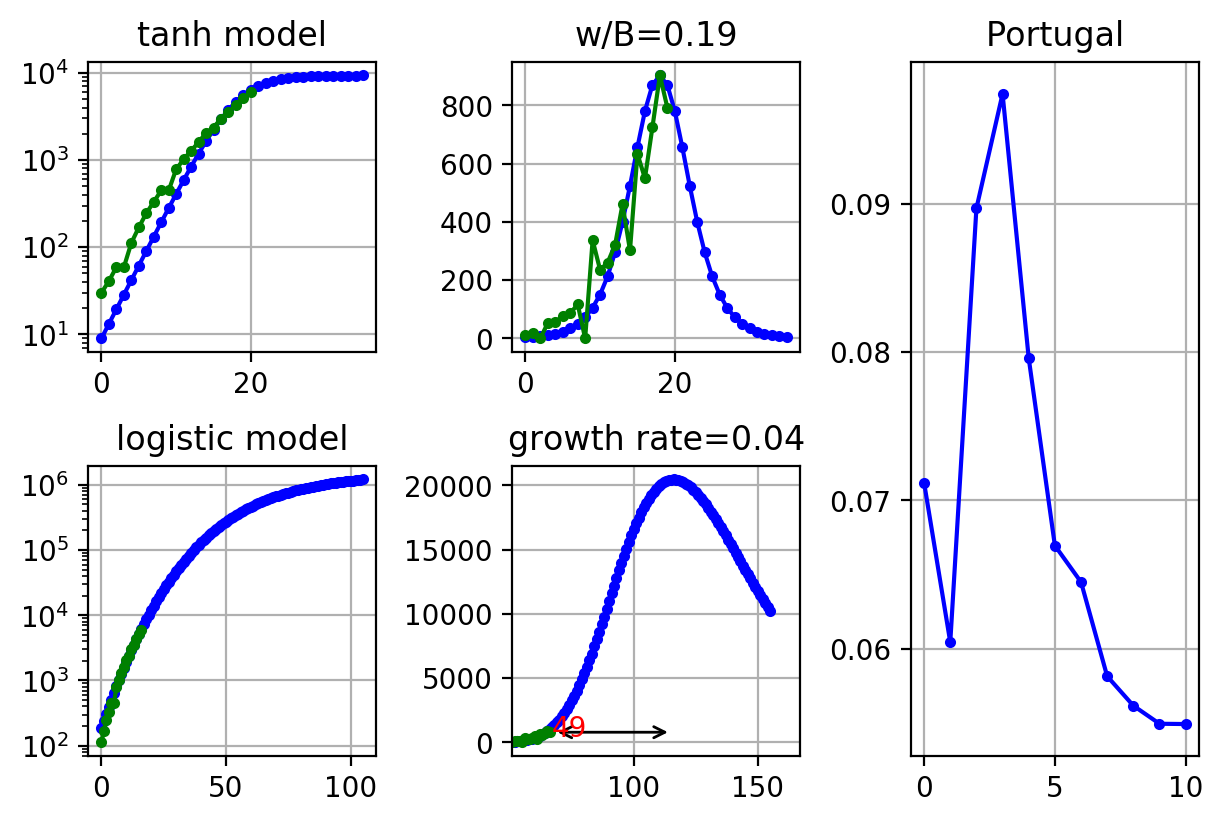

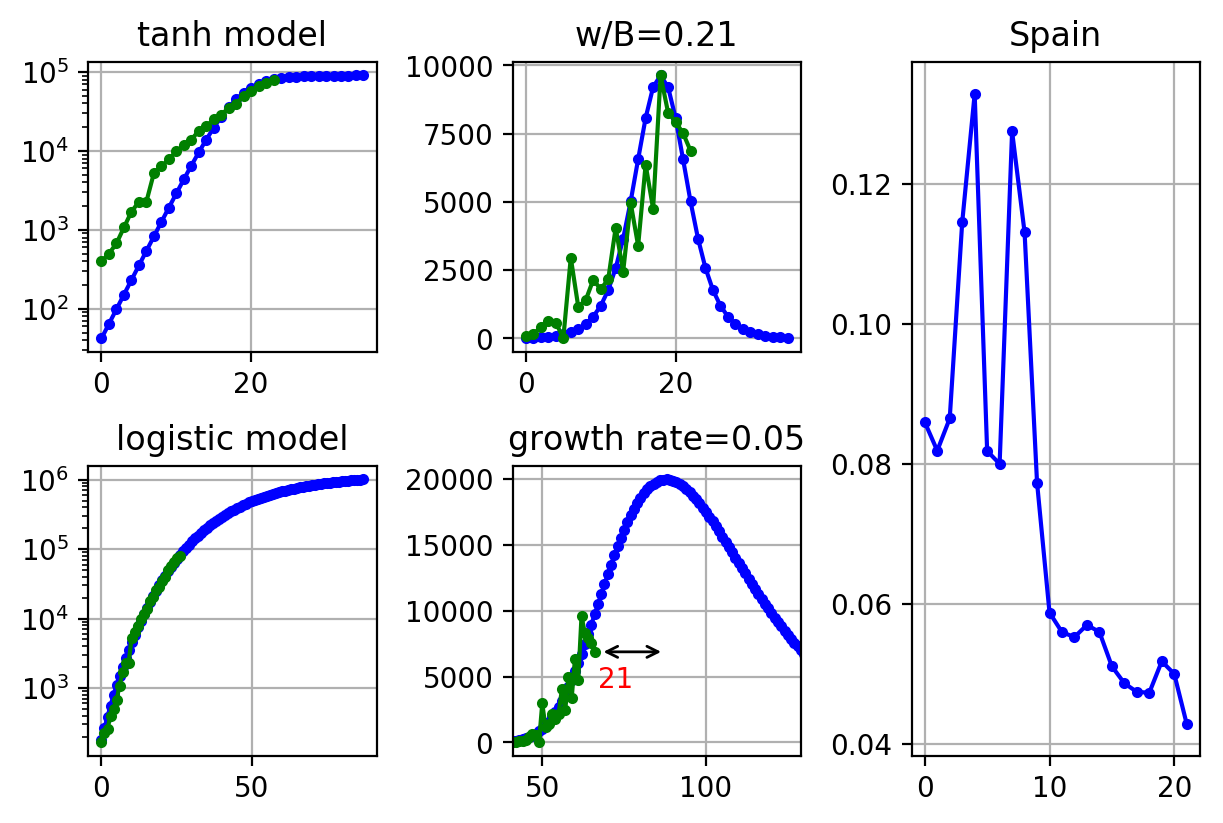

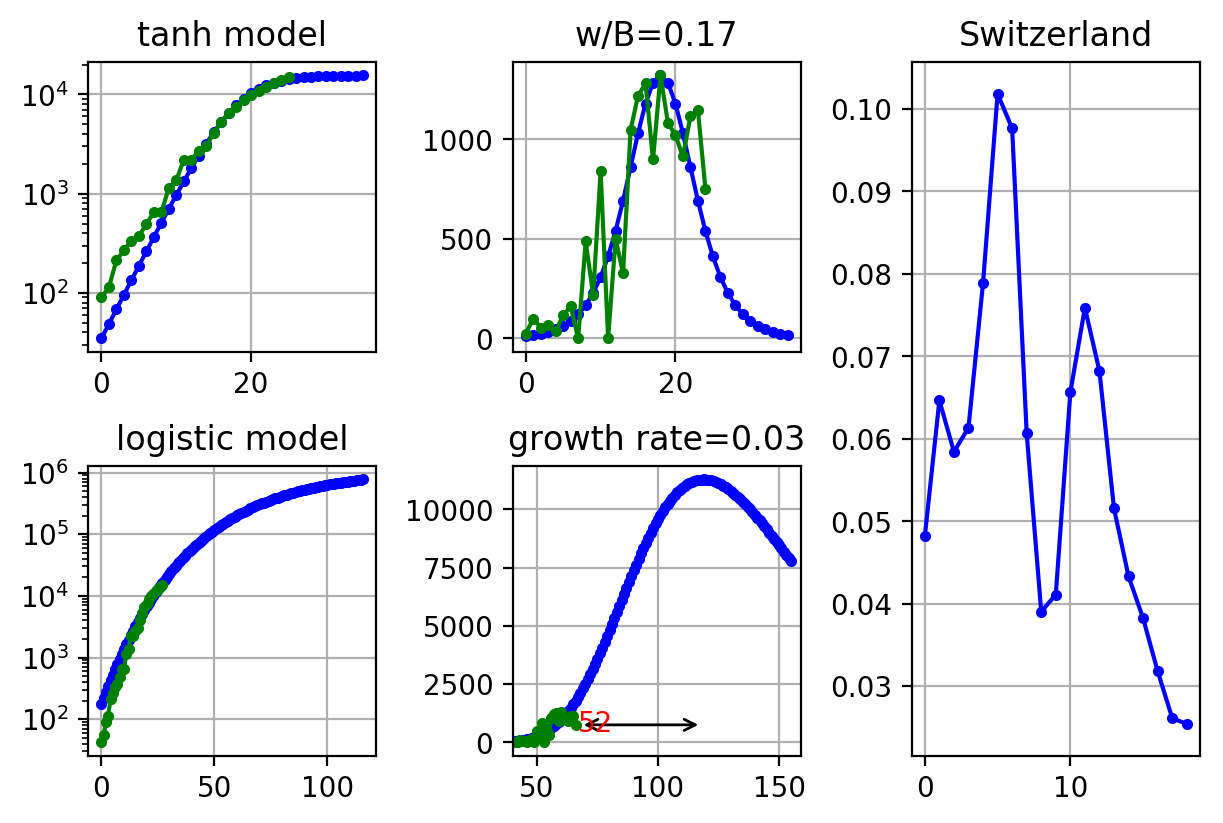

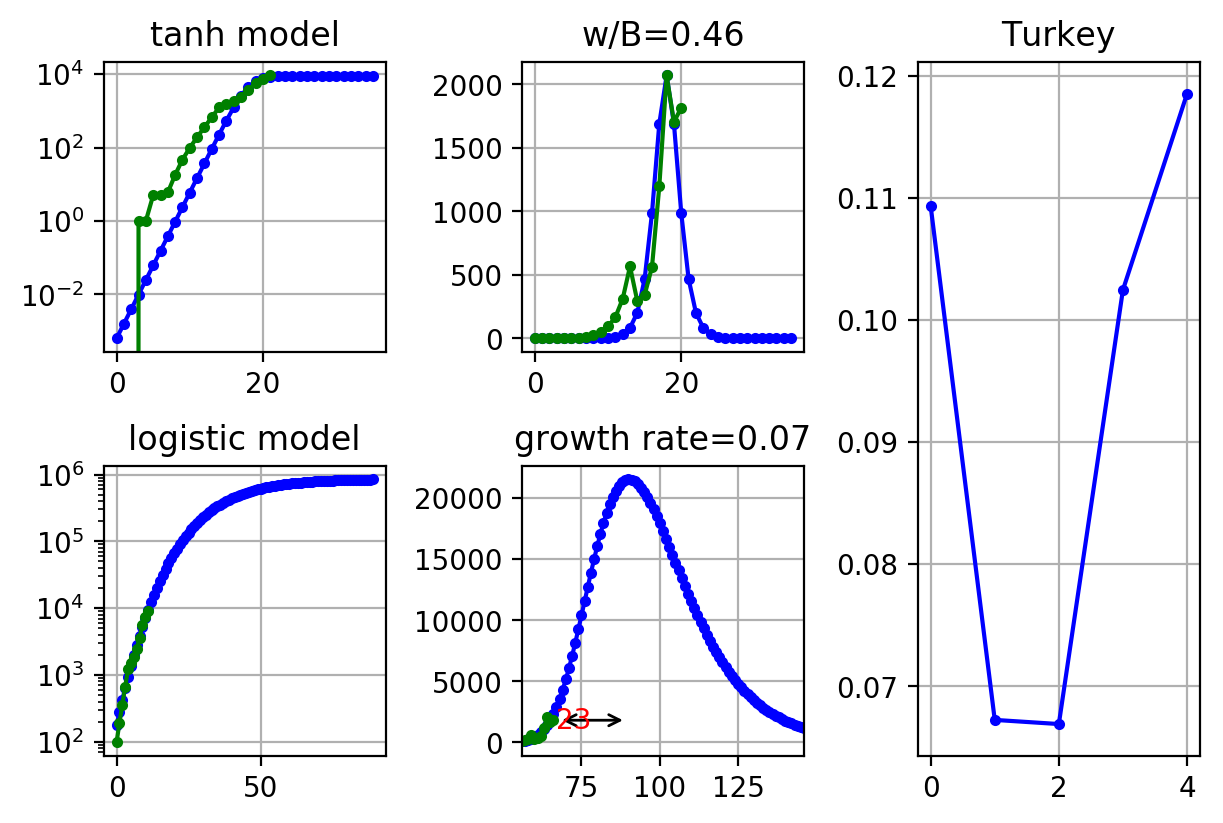

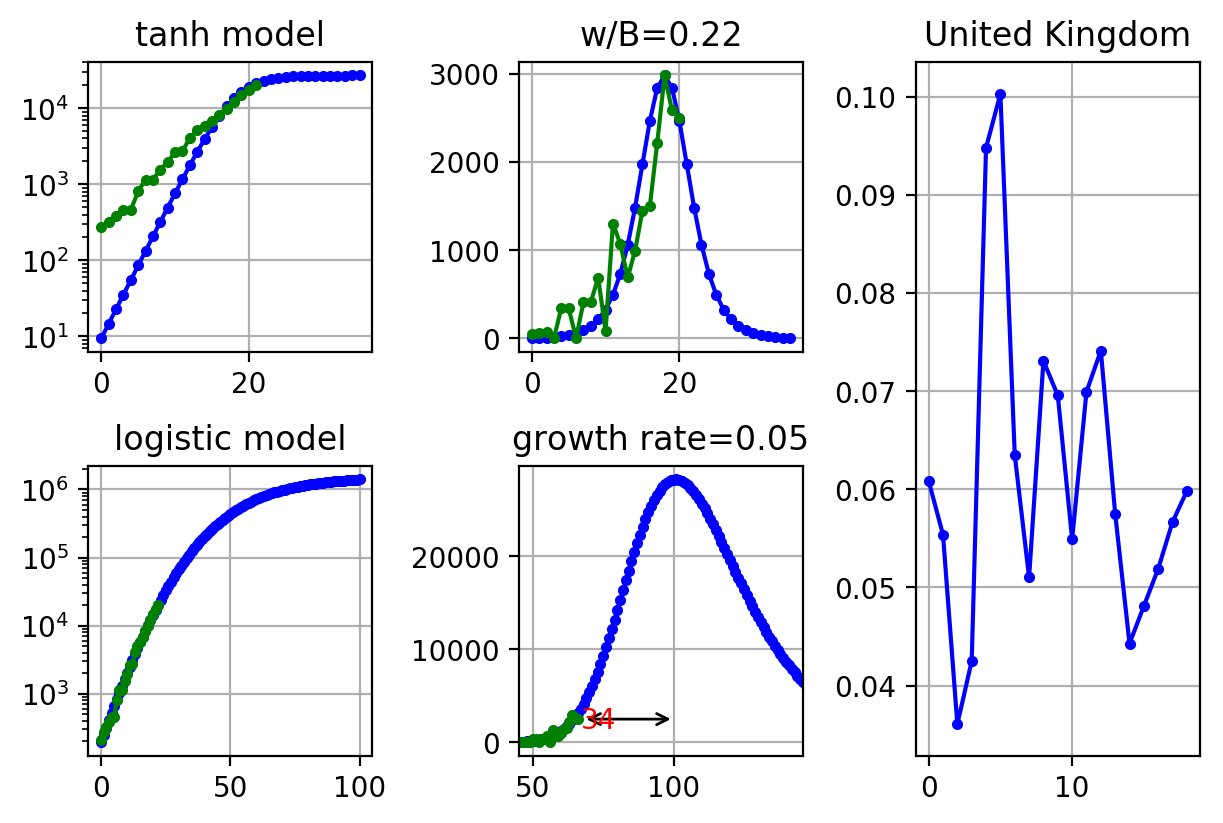

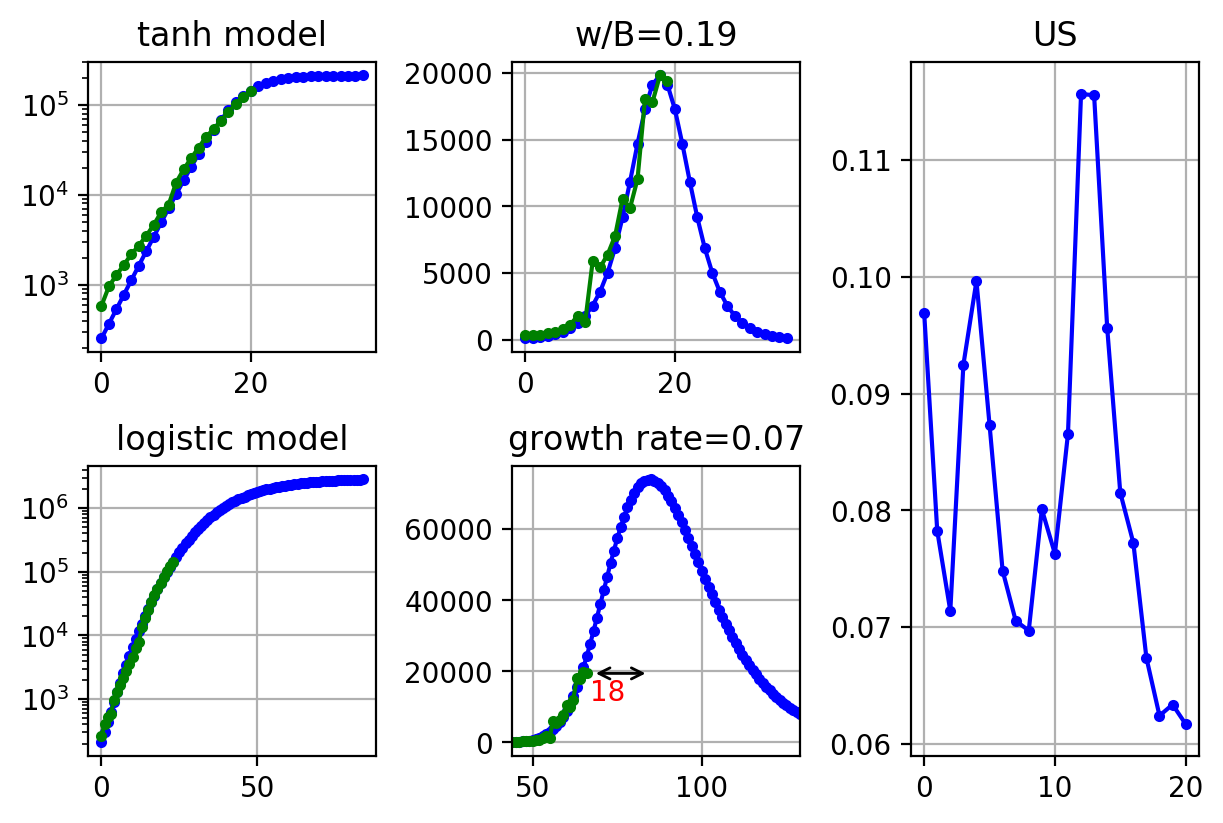

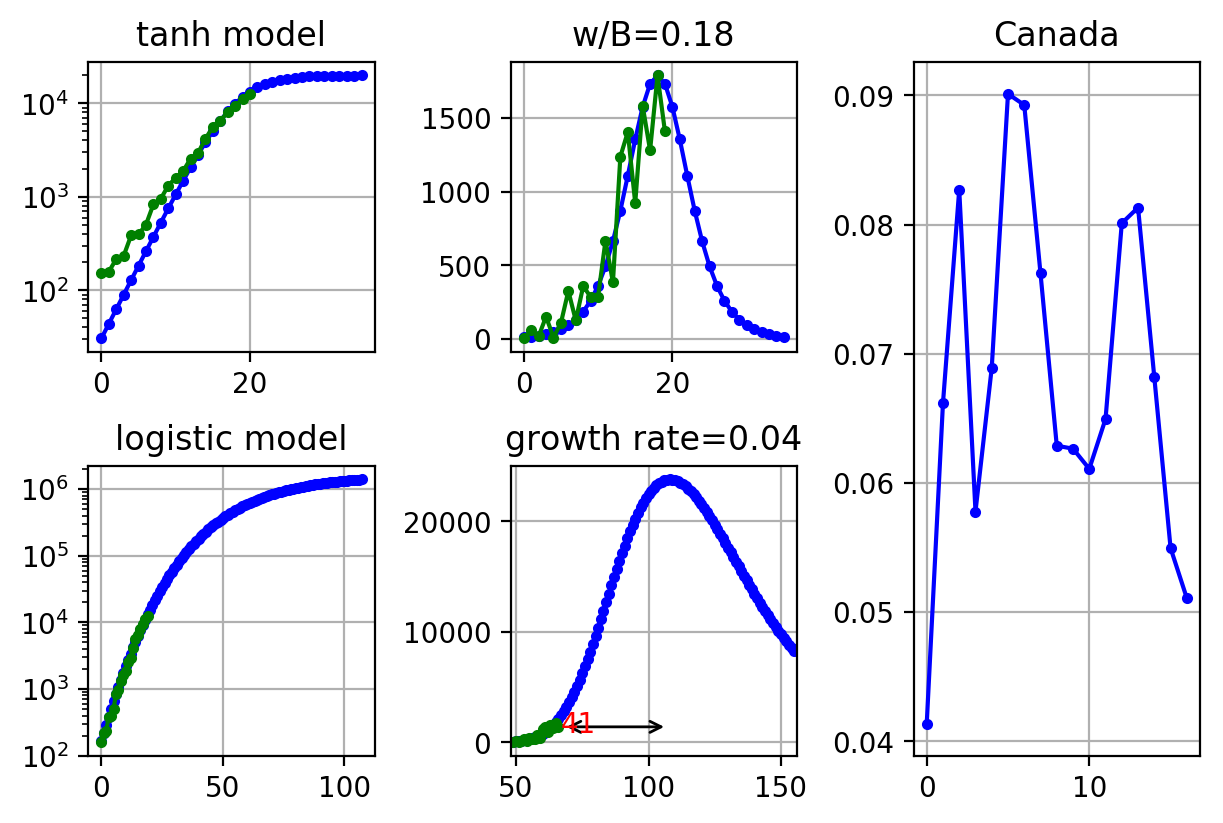

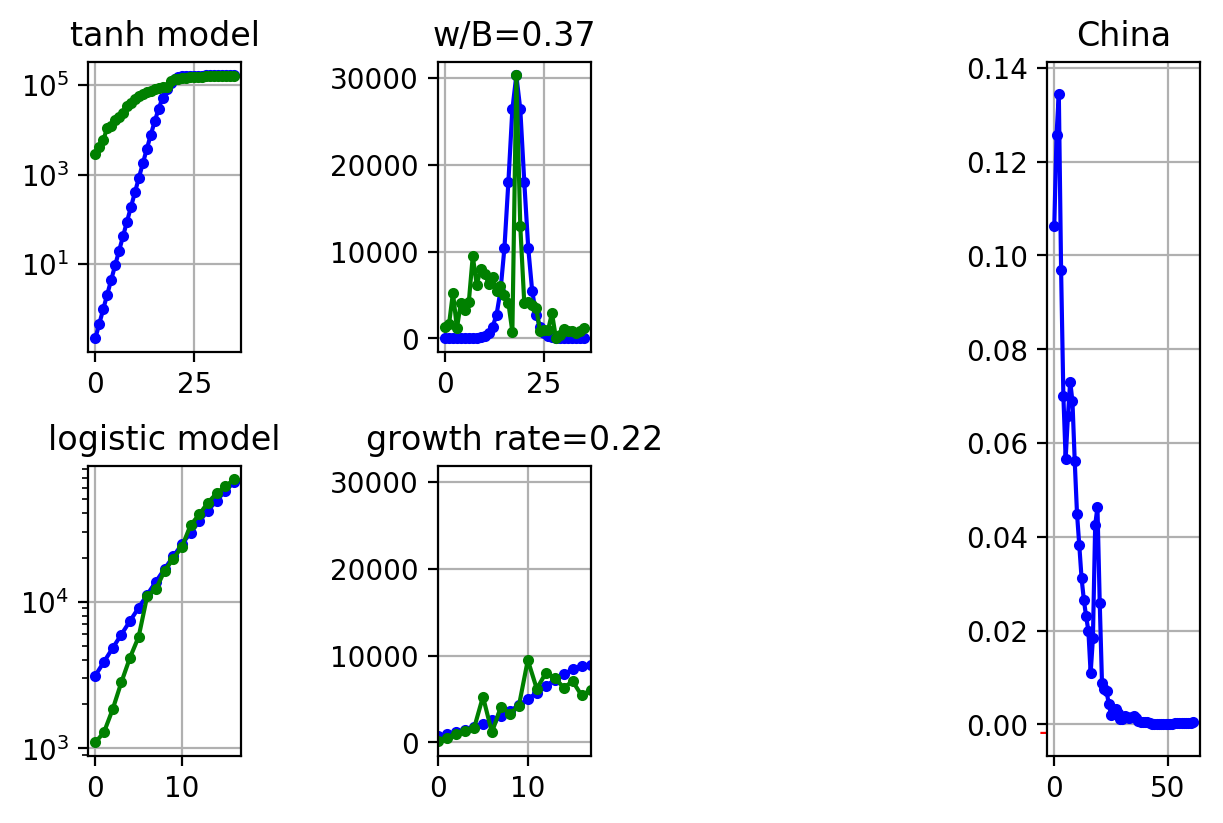

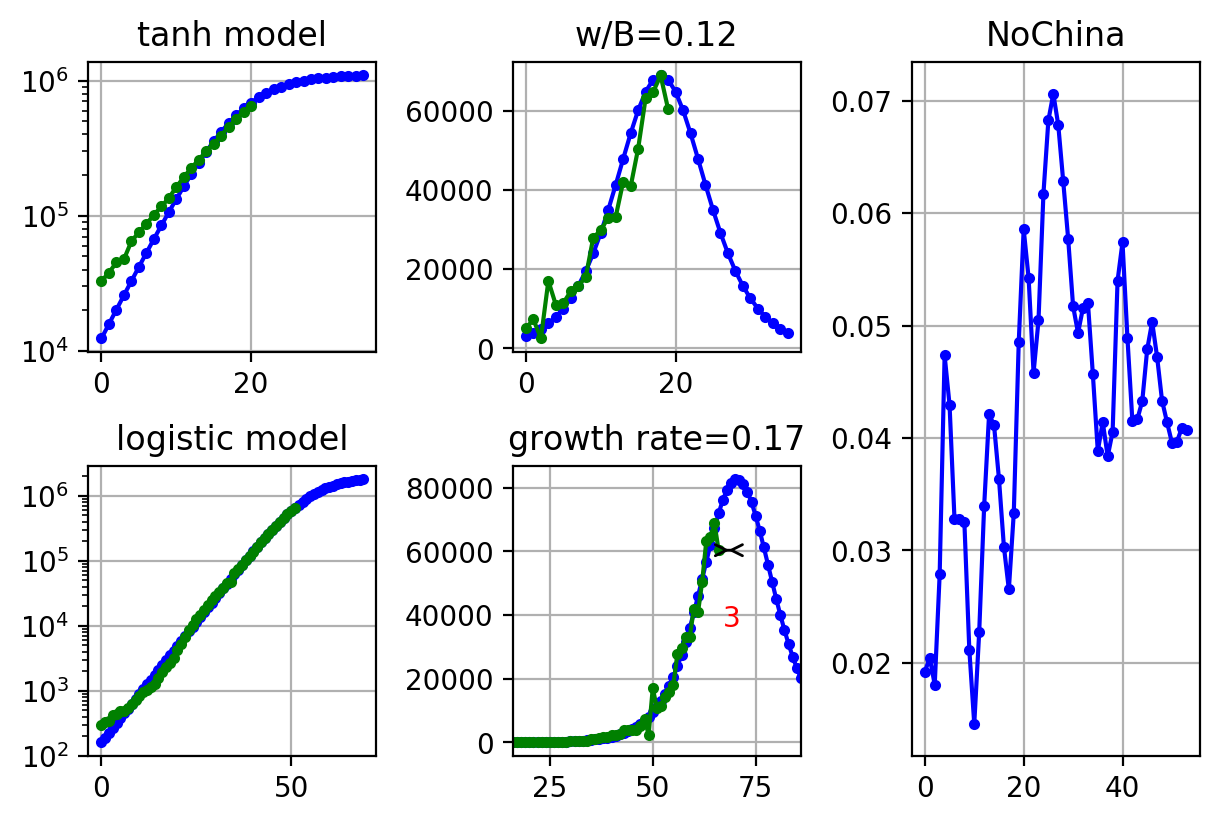

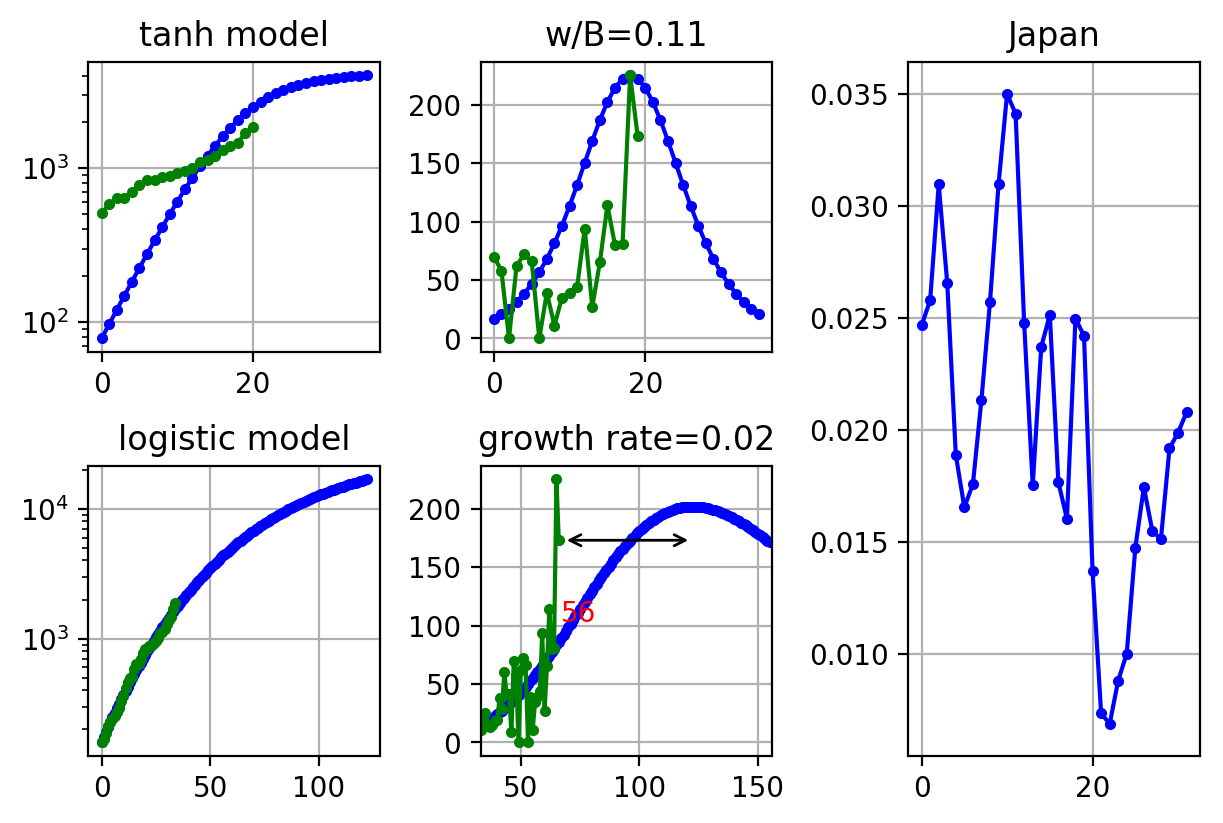

In [25]:
for ctr in  countriesFocused:#["US"]:#

    # get daily change, drop first value, '0'
    v = dataJHU.loc[ctr].sum().diff().values[1:]
    y = dataJHU.loc[ctr].sum().values
    
    #A/C are derived, 
    A=max(v)
    C=np.argmax(v)
    
    # first run wiht a good set then adjust to target (for example run with south kora)    
    # this is width variable, smaller means slower groth (this is a gAuss)
    
    t = np.arange(0,sp.size(y))
    f = lambda t,B: newcModel(t, A, B, C)
    paramsB, params_covariance = optimize.curve_fit(f, t, y, p0=[.2])
    B=paramsB[0]
    
    # did not work well,lowered value of B
    f = lambda t,A,B: newcModel(t, A, B, C)
    paramsAB, params_covariance = optimize.curve_fit(f, t, y, p0=[A*1,.2],bounds=([A*0,-np.inf],[np.inf,np.inf]))
    Ae=paramsAB[0]
    Be=paramsAB[1]    
    #print("%14s - %f:%f | %5d:%5d "%(ctr,B,Be, A,Ae))
    
    # trying use function wiht more arguments
    fLogistic = lambda t,K,B,Q,v: logisModel(t,K=K,Q=Q,B=B,v=v,M=C)
    params, params_covariance = optimize.curve_fit(fLogistic,t,y, bounds=([0,.02,0,0],[1e7,0.5,3,1]))    
    #  US: K(779574.78) B(0.11) Q(0.55) v(0.18)
    #  US: K(3336778.33) B(0.08) Q(0.98) v(0.17)

    #number of samples to plot is inversely releated to B
    M = 18# 2.5 weeks

    # must be in days
    N=sp.size(v)
    t = np.arange(0,N+90)        
    
    A = A
    B = B
    id= 0

    
    #fig, ax = plt.subplots(2,3,)
    fig  = plt.figure(constrained_layout=True)
    spec = fig.add_gridspec(2, 3)
    ax00 = fig.add_subplot(spec[0, 0])
    ax10 = fig.add_subplot(spec[1, 0])
    ax01 = fig.add_subplot(spec[0, 1])
    ax11 = fig.add_subplot(spec[1, 1])
    ax2  = fig.add_subplot(spec[:,2])
    
    #tanh/sinc^2 model (antonio)
    yh =newcModel(t,A,B,C)
    vh = cumModel(t,A,B,C)
    
    ax00.semilogy(yh[C-M:C+M])    
    ax00.semilogy(y[C-M:C+M])
    ax00.grid()
    ax00.set_title("tanh model")
    
    ax01.plot(vh[C-M:C+M])
    ax01.plot(v[C-M:C+M])
    ax01.grid()     
    ax01.set_title("w/B=%.2f" % B)         
    #logistic model,has more parameters but similar to above
    yh = fLogistic(t,params[0],params[1],params[2],params[3])    
    vh = np.diff(yh)
    # start index
    Ns = np.argwhere(yh>150)[0][0]
    Np = vh.argmax()    
    NtoP=Np-sp.size(v);
    print("{ctr:>14} K={K:,} B={B:.2f} Q={Q:.2f} v={v:.2f} Ndays to peak=({N})".format(
        ctr=ctr, K=int(params[0]),B=params[1],Q=params[2],v=params[3],N=NtoP
        ))        
    
    ax10.semilogy(yh[Ns:Np+Ns])
    ax10.semilogy(y[Ns:Np+Ns])
    ax10.grid();
    ax10.set_title("logistic model")

    
    ax11.plot(vh)    
    ax11.plot(v)    
    ax11.grid()    
    ax11.set_xlim([Ns,Np+Ns])
    
    ax11.set_title("growth rate=%.2f"%params[1])   
    ax11.annotate("", xy=(sp.size(v), v[-1]), xytext=(Np, v[-1]),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
    ax11.text(sp.size(v), int(v[-1]*.6),"%d"%(NtoP),  {'color': 'red', 'fontsize': 10})

    
    getTimedGrowthRate(dataJHU,pd.IndexSlice[ctr,"NA",:,:]);
    vGR= getTimedGrowthRate(dataJHU,ctr)
    ax2.plot(vGR)
    ax2.grid()
    ax2.set_title(ctr)

# align set of countries and determine days  apart

ideally should  normalize too, but is that fare comparision, should really compare states in cities based on density and social programs and cleansiness

        Austria 2020-03-11:-16
        Belgium 2020-03-09:-14
         France 2020-03-03:-8
        Germany 2020-03-04:-9
           Iran 2020-02-27:-3
          Italy 2020-02-24:0
   Korea, South 2020-02-21:3
    Netherlands 2020-03-08:-13
          Spain 2020-03-04:-9
    Switzerland 2020-03-06:-11
         Turkey 2020-03-20:-25
 United Kingdom 2020-03-07:-12
             US 2020-03-05:-10
          China 2020-01-22:33
        NoChina 2020-02-04:20


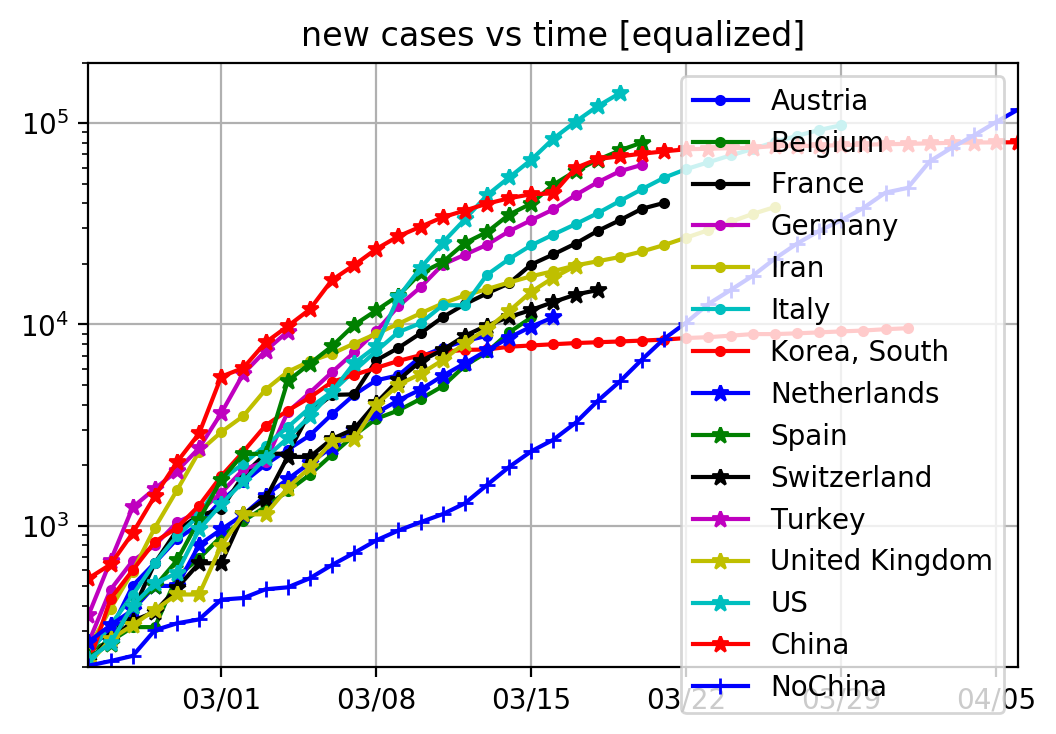

In [37]:
# 


N= 200;# number of sample to align too
M= 8000;# minimum case count
# find reference time stamp of passing N samples                  
idx = pd.IndexSlice
id = np.argmax((dataJHU.loc[idx["Italy",:,:,:],:]> N).values[0]==True)
dtRef = dataJHU.columns[id]

dt = dataJHU.columns[-1]
                  
fig, ax=plt.subplots(1,1)
#only consider countires with large number of cases
for index, row in dataJHU[dataJHU[dt]>M].iterrows():
    ctr =index[0]    
    #ignore states
    if index[1] != "NA": continue 
    #equalize start data to be at N cases and to ref country (US)
    dtg = row[row>N].first_valid_index()
    do  = datetime.timedelta((dtRef - dtg).days)
    print("%15s %s:%d"%(ctr,dtg.date(),do.days))
    #do  =datetime.timedelta(days=offsets[ctr])
    vdt = [(d +do).date()#.strftime("%m/%d")
           for d in dataJHU.columns]
    
    ax.semilogy(vdt,row.values, label=ctr)

#control range to zoom regio of interest
ax.set_ylim(N, 2e5)
ax.set_xlim(dtRef, datetime.date.today()+datetime.timedelta(7))
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("new cases vs time [equalized]");


# predict the 'US' covid-19 number of illness

will adapt the rate, note this will only reflect the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)

the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)

https://en.wikipedia.org/wiki/Generalised_logistic_function

assuming a groth rate of 10%

where will the us be


NameError: name 'dataCS' is not defined

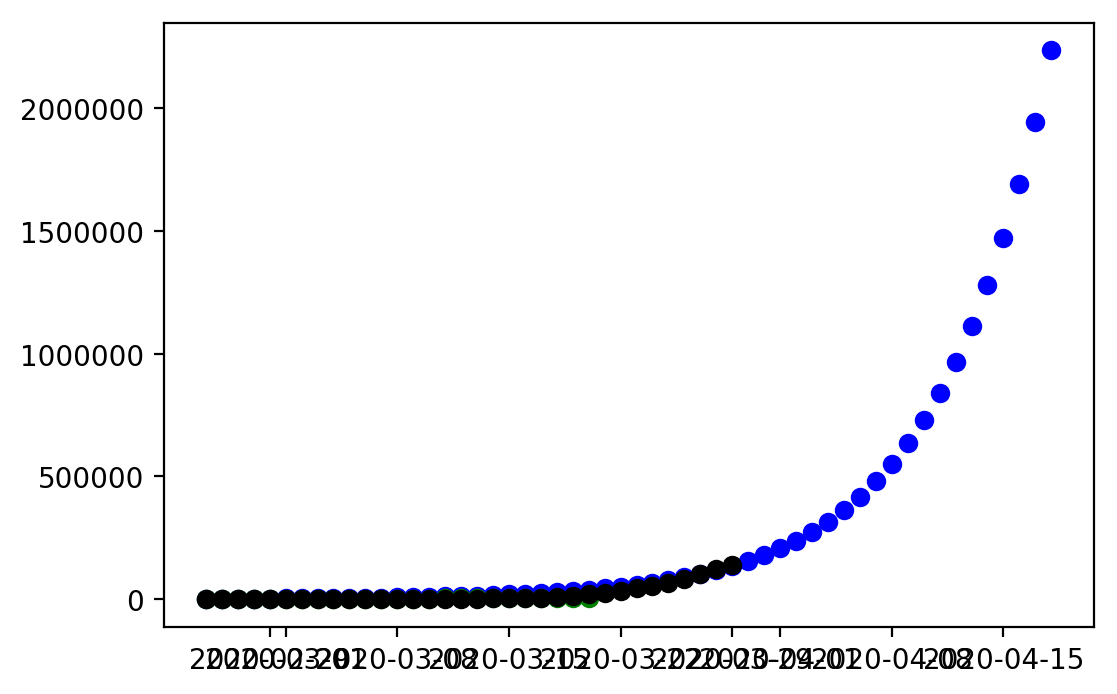

In [27]:
# 
# use JHU
# estimate US data

idx = pd.IndexSlice

#find cumulateive greater then 50, this will be y0
startDate = dataCdc[dataCdc>250].index[0]
rate = .14

#start from scratch take y[0] and assume X% groth and assume, y0 was 20% report of all reporting (multiply by 5)
# get number of samples in the data base
N = (datetime.date.today()-startDate).days

#project for another 2 week
NP = 20
NEC = (datetime.date.today()    -dataCdc.index[-1]).days-1
NEJ = (datetime.datetime.today()-dataJHU.columns[-1] ).days-1


# projection (assume multipler of 5)
yh = dataCdc[startDate] * 5 * np.exp(rate * np.arange(0,N+NP))
yh=yh.astype(int)

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)

ax.plot_date(x,
             yh,
             label="model")
ax.plot_date(x[0:(N-NEC)],
             dataCdc[startDate:].values,
             label="actual-CDC")
ax.plot_date(x[0:(N-NEJ)],
             dataJHU.loc["US",startDate:].sum().values,
             label="actual-JHU")
ax.plot_date(datetime.date.today(),
             dataCS.loc[idx["NA", "NA", "NA", "USA"],"cases"],
            label="3rd source")

ax.plot_date(datetime.date.today(),
        dataCovTr["positive"],
        label="covidtracking")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("model vs observed")
ax.set_ylim(1e4, 2e5)


yc = np.concatenate([dataCdc.loc[startDate:].values,
                     np.nan * np.ones(NP+NEC)])


yj = np.concatenate([dataJHU.loc["US",startDate:].sum().values,
                    np.nan * np.ones(NP+NEJ)])


if(1):
    df =pd.DataFrame({"model": yh,
                  "cdc"  : yc,
                  "jhu"  : yj},index=x)
    #print(df)


# predict the 'No-China' covid-19 number of illness


2020-03-07 00:00:00


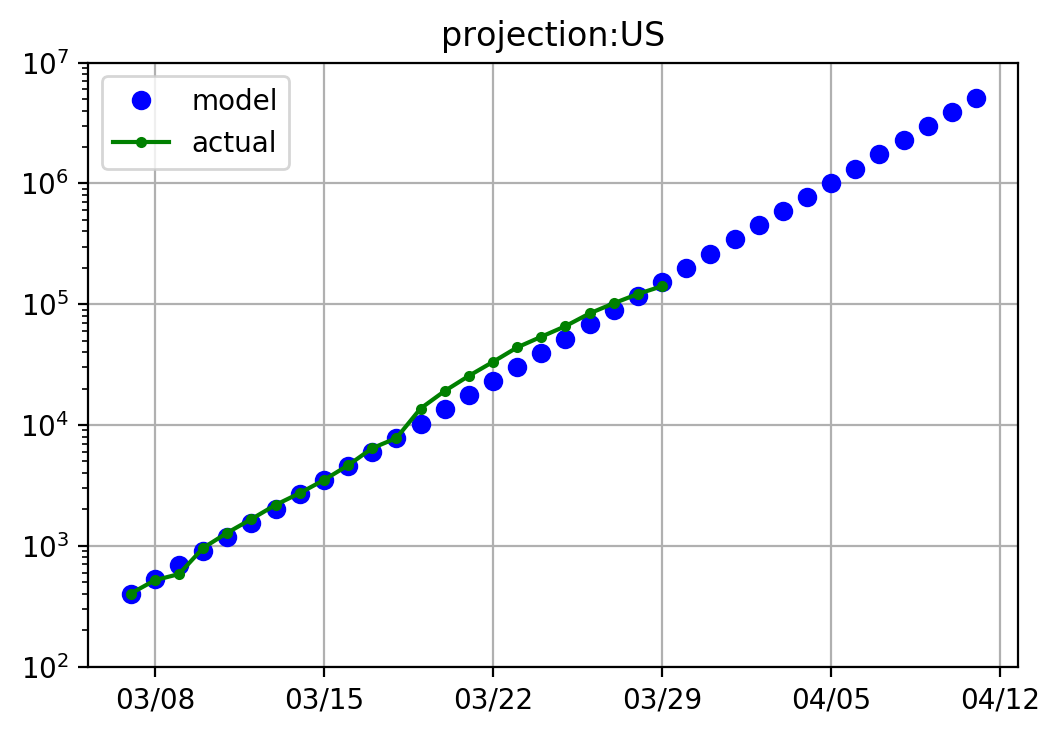

In [30]:


#start date
rate      = .27
ctr       = "US"
caseMin   = 300
TN        = 14    # number of intervals after today

s = dataJHU.loc[ctr].sum()
startDate = s[s>caseMin].index[0]

print(startDate)

#nmber of intervals
N  = sp.size(dataJHU.columns)


# Set the epoch value
Y0 = dataJHU[startDate][ctr].sum()
#determine time offset
offset = (dataJHU.columns[-1]-startDate).days
Yt =Y0 * sp.exp(rate * np.arange(0,offset + TN))

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,offset + TN)]
NE = (datetime.datetime.today()-dataJHU.columns[-1] ).days


fig,ax = plt.subplots(1,1)
ax.plot_date(x,
             Yt,
             label="model")

ax.plot(dataJHU.loc[ctr,startDate:].sum(),
        label="actual")

ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("projection:%s"%ctr)
ax.set_ylim(1e2, 1e7)
plt.yscale('log')

# San Diego Data

also saves the data to create a time series

In [33]:
#script for scraping HTML sites 
# investigate  java scripts for cleaner solution, need to inspect and find source
import re,pickle, requests
try:
    from bs4 import BeautifulSoup
except ImportError:
    !pip install packaging
    from bs4 import BeautifulSoup


URL = 'https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')




table = soup.find("div",{"class":"table parbase section"})
rows = table.find_all('tr')
 
# handle header
header = [row.text for row in rows[1].find_all('td')]
header = [re.sub('[ \t\n]+', ' ',h)  for h in header]

tbl ={}
for row in rows[2:]: #skip the first row
    data = [r.text for r in row.find_all('td')]    
    if data[1] =='\xa0':continue    
    tbl[data[0]]=[int(d) for d in data[1:]]
df = pd.DataFrame(tbl, index=header[1:])
display(HTML(df.to_html()))
updateDateTime = re.search("Table updated (.*? 2020)",rows[0].find('td').text)[1]
#updateDateTime = rows[0].find('td').text.split('\n')[-1].replace("Updated","")
print("last update is %s" % updateDateTime )

dt = datetime.datetime.strptime(updateDateTime.strip(),"%B %d, %Y")
# get data
data = pickle.load( open( "sandiego.tseries.p", "rb" ) )
if not dt in data.keys():
    print("saving new data, with key %s" %dt)
    data[dt] =df
    pickle.dump(data,open("sandiego.tseries.p",'wb'))

,Total Positives,0-9 years,10-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60-69 years,70-79 years,80+ years,Age Unknown,Female,Male,Unknown,Hospitalizations,Intensive Care,Deaths
San Diego County Residents,519,4,6,107,130,90,79,37,39,26,1,219,298,2,106,47,7


last update is March 29, 2020


2020-03-17 = 60
2020-03-18 = 80
2020-03-19 = 105
2020-03-20 = 131
2020-03-21 = 159
2020-03-22 = 205
2020-03-23 = 230
2020-03-24 = 242
2020-03-25 = 297
2020-03-26 = 341
2020-03-29 = 519


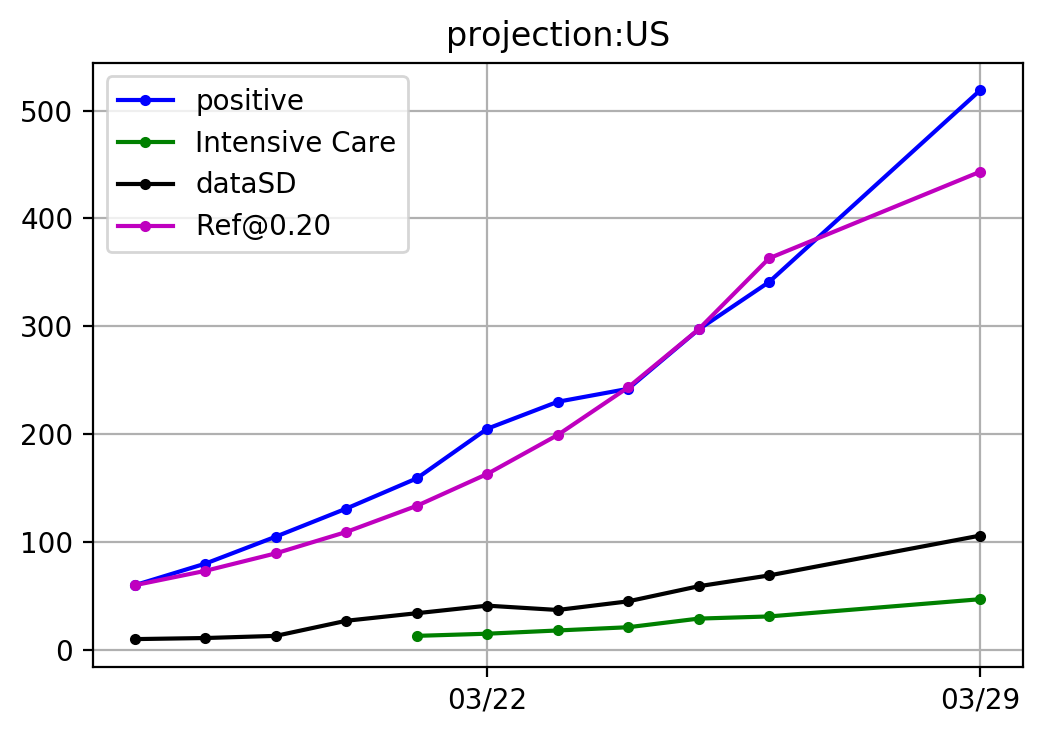

In [35]:
data = pickle.load(open("sandiego.tseries.p",'rb'))
columns = list(data.values())[-1].columns
dataSD = pd.DataFrame(columns=columns)


idx=0
for k in data.keys(): 
    df= data[k]
    ki = "Total" if "Total" in df.index else "San Diego County Residents"
    print("%s = %d" % (k.date(),df["Total Positives"][ki]))
    d = df.loc[ki].to_dict()
    for kk in d.keys():        
        dataSD.loc[idx,kk]= d[kk]
    dataSD.loc[idx,"Date"]=k
    idx+=1;
# combine two hospitalized columns
dataSD['Hospitalizations'].fillna(dataSD['Hospitalized'],inplace=True)


fig,ax=plt.subplots(1,1)
ax.plot(dataSD["Date"],dataSD["Total Positives"], label="positive")
ax.plot(dataSD["Date"],dataSD["Intensive Care"],  label="Intensive Care")
ax.plot(dataSD["Date"],dataSD["Hospitalizations"],    label="dataSD")
N=sp.size(dataSD.index)
rate=0.20
ax.plot(dataSD["Date"],dataSD["Total Positives"][0] * np.exp(rate*np.arange(0,N)),          label="Ref@%.2f"%rate)
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("projection:%s"%ctr);


Text(0.5, 1.0, 'age distribution')

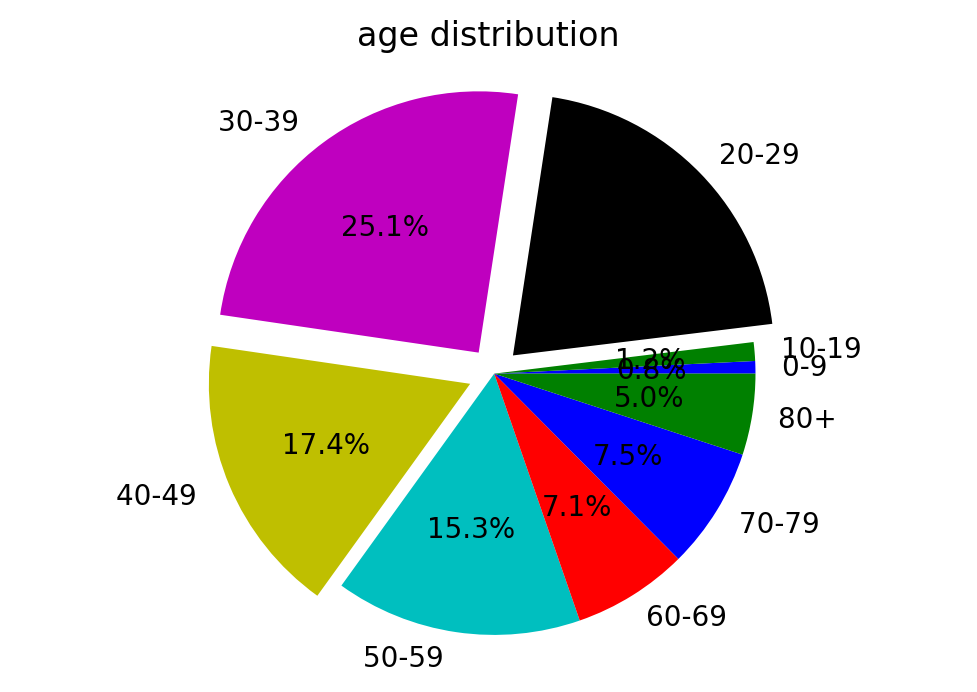

In [36]:
g = dataSD.filter(like="years",axis=1).iloc[-1].dropna()
fig1, ax1 = plt.subplots()
ax1.pie(g.values, 
        explode=(g/sum(g) * 100 >17)* .1,
        labels=g.index.str.replace("years",''), 
        autopct='%1.1f%%',)
ax1.axis('equal');
ax1.set_title("age distribution")
